# Bibliotecas

In [624]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns 
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_validate,validation_curve, learning_curve, GridSearchCV, RandomizedSearchCV
import xgboost as xgb
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, roc_auc_score, roc_curve, classification_report, precision_recall_curve, average_precision_score

import warnings
warnings.filterwarnings("ignore", category=UserWarning)

# Dados

In [625]:
df_original = pd.read_csv("dataset/rh_data.csv")
# Mostrar todas as colunas
pd.set_option('display.max_columns', None)
df_original.head()

,Age,Attrition,BusinessTravel,Department,DistanceFromHome,Education,EducationField,EmployeeCount,EmployeeID,Gender,JobLevel,JobRole,MaritalStatus,MonthlyIncome,NumCompaniesWorked,Over18,PercentSalaryHike,StandardHours,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,YearsAtCompany,YearsSinceLastPromotion,YearsWithCurrManager
0,51,No,Travel_Rarely,Sales,6,2,Life Sciences,1,1,Female,1,Healthcare Representative,Married,131160,1.0000,Y,11,8,0,1.0000,6,1,0,0
1,31,Yes,Travel_Frequently,Research & Development,10,1,Life Sciences,1,2,Female,1,Research Scientist,Single,41890,0.0000,Y,23,8,1,6.0000,3,5,1,4
2,32,No,Travel_Frequently,Research & Development,17,4,Other,1,3,Male,4,Sales Executive,Married,193280,1.0000,Y,15,8,3,5.0000,2,5,0,3
3,38,No,Non-Travel,Research & Development,2,5,Life Sciences,1,4,Male,3,Human Resources,Married,83210,3.0000,Y,11,8,3,13.0000,5,8,7,5
4,32,No,Travel_Rarely,Research & Development,10,1,Medical,1,5,Male,1,Sales Executive,Single,23420,4.0000,Y,12,8,2,9.0000,2,6,0,4


## Cópia do DataFrame Original

In [626]:
# Cópia do DataFrame original
df = df_original.copy()

# Análise Inicial

## Verificando a Quantidade de Linhas e Colunas

In [627]:
# Verificando a quantidade de linhas e colunas
df.shape

(4410, 24)

## Verificando os Tipos de Dados

In [628]:
# Verificando os tipos de dados
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4410 entries, 0 to 4409
Data columns (total 24 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Age                      4410 non-null   int64  
 1   Attrition                4410 non-null   object 
 2   BusinessTravel           4410 non-null   object 
 3   Department               4410 non-null   object 
 4   DistanceFromHome         4410 non-null   int64  
 5   Education                4410 non-null   int64  
 6   EducationField           4410 non-null   object 
 7   EmployeeCount            4410 non-null   int64  
 8   EmployeeID               4410 non-null   int64  
 9   Gender                   4410 non-null   object 
 10  JobLevel                 4410 non-null   int64  
 11  JobRole                  4410 non-null   object 
 12  MaritalStatus            4410 non-null   object 
 13  MonthlyIncome            4410 non-null   int64  
 14  NumCompaniesWorked      

Duas colunas numéricas estão como float mas deveriam ser inteiras (NumCompaniesWorked, TotalWorkingYears).  
Isso pode indicar valores ausentes (NaNs). 
Colunas originalmente inteiras que aparecem como float geralmente indicam presença de NaN,  
porque o pandas precisa de um tipo que aceite valores nulos, e int tradicional não aceita.

- A variável deveria ser int
- Está como float por causa dos NaN
- O tipo só pode ser convertido após o tratamento dos valores ausentes

## Verificando Duplicados

In [629]:
# Quantidade de linhas duplicadas
df.duplicated().sum()

np.int64(0)

## Verificando Colunas com Valor Único

In [630]:
# Verificando se há valores repetidos ao londo de colunas
df.nunique()

Age                          43
Attrition                     2
BusinessTravel                3
Department                    3
DistanceFromHome             29
Education                     5
EducationField                6
EmployeeCount                 1
EmployeeID                 4410
Gender                        2
JobLevel                      5
JobRole                       9
MaritalStatus                 3
MonthlyIncome              1349
NumCompaniesWorked           10
Over18                        1
PercentSalaryHike            15
StandardHours                 1
StockOptionLevel              4
TotalWorkingYears            40
TrainingTimesLastYear         7
YearsAtCompany               37
YearsSinceLastPromotion      16
YearsWithCurrManager         18
dtype: int64

Essa análise foi feita para identificar colunas com valor constante, que não agregam informação para o modelo.

EmployeeCount, Over18 e StandardHours têm apenas um valor único que se repete e, por isso, serão removidas.

EmployeeID é um identificador único, então também não deve ser usada como variável preditora.

### Excluindo Colunas com Valor Único

In [631]:
colunas_valor_unico = [col for col in df.columns if df[col].nunique() == 1]
df.drop(columns=colunas_valor_unico, inplace=True)

## Verificando Nulos

In [632]:
# Variáveis com valores nulos
df.isnull().sum()

Age                         0
Attrition                   0
BusinessTravel              0
Department                  0
DistanceFromHome            0
Education                   0
EducationField              0
EmployeeID                  0
Gender                      0
JobLevel                    0
JobRole                     0
MaritalStatus               0
MonthlyIncome               0
NumCompaniesWorked         19
PercentSalaryHike           0
StockOptionLevel            0
TotalWorkingYears           9
TrainingTimesLastYear       0
YearsAtCompany              0
YearsSinceLastPromotion     0
YearsWithCurrManager        0
dtype: int64

### Inspecionando coluna com campos nulos em TotalWorkingYears

In [633]:
# Inspecionando as linhas onde 'TotalWorkingYears' é nulo
df[df['TotalWorkingYears'].isnull()].head(9)

,Age,Attrition,BusinessTravel,Department,DistanceFromHome,Education,EducationField,EmployeeID,Gender,JobLevel,JobRole,MaritalStatus,MonthlyIncome,NumCompaniesWorked,PercentSalaryHike,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,YearsAtCompany,YearsSinceLastPromotion,YearsWithCurrManager
23,42,No,Travel_Rarely,Research & Development,4,4,Life Sciences,24,Male,1,Manufacturing Director,Married,89260,1.0000,14,0,NaN,4,20,11,6
137,43,No,Travel_Frequently,Sales,14,3,Life Sciences,138,Female,1,Manufacturing Director,Married,37480,7.0000,14,2,NaN,3,3,1,2
308,47,Yes,Travel_Frequently,Research & Development,4,3,Life Sciences,309,Male,1,Research Director,Single,27740,4.0000,13,1,NaN,2,5,1,3
574,37,No,Travel_Rarely,Research & Development,23,3,Life Sciences,575,Male,3,Manufacturing Director,Divorced,166590,7.0000,16,1,NaN,2,6,1,3
1517,36,No,Non-Travel,Research & Development,5,4,Life Sciences,1518,Male,1,Sales Executive,Married,85780,7.0000,21,0,NaN,4,9,0,8
2367,39,No,Travel_Rarely,Sales,2,4,Life Sciences,2368,Male,1,Laboratory Technician,Divorced,72640,0.0000,17,0,NaN,5,10,0,7
3120,35,No,Travel_Rarely,Research & Development,12,2,Medical,3121,Female,2,Sales Representative,Married,28090,4.0000,23,1,NaN,2,8,0,0
3818,28,Yes,Travel_Rarely,Human Resources,1,3,Medical,3819,Female,2,Laboratory Technician,Married,24130,1.0000,16,1,NaN,2,1,0,0
4409,40,No,Travel_Rarely,Research & Development,28,3,Medical,4410,Male,2,Laboratory Technician,Divorced,54680,0.0000,12,0,NaN,6,21,3,9


### Analisando a relação entre TotalWorkingYears e NumCompaniesWorked

1. Se **NumCompaniesWorked** (número de empresas em que trabalhou) é igual a "0" a pessoa nunca trabalhou em outra empresa.
2. Porém, se **TotalWorkingYears** (anos totais de experiência profissional) é **maior** do que **YearsAtCompany** (anos na empresa atual),  
indica diferentes interpretações sobre a contagem de anos de experiência.

In [634]:
# Verificando a lógica na quantidade de anos de trabalho total se empresas trabalhadas é zero
df[(df['NumCompaniesWorked'] == 0) & (df['TotalWorkingYears'] > df['YearsAtCompany'])].shape

(584, 21)

584 registros mostram que pode haver 'TotalWorkingYears' maior que 'YearsAtCompany' e ainda assim 'NumCompaniesWorked' ser 0.  
Ou seja, a pessoa pode ter trabalhado em outro lugar, mas pela regra de negócios não conta como experiência em outra empresa.

Dessa forma, podemos inferir que quando 'NumCompaniesWorked' = 0, 'TotalWorkingYears' = 'YearsAtCompany'.

In [635]:
# Subistituindo os valores nulos de 'TotalWorkingYears' por 'YearsAtCompany' quando 'NumCompaniesWorked' é 0
df.loc[(df['TotalWorkingYears'].isnull()) & (df['NumCompaniesWorked'] == 0), 'TotalWorkingYears'] = df['YearsAtCompany']

In [636]:
# Inspecionando as linhas onde 'TotalWorkingYears' é nulo
df[df['TotalWorkingYears'].isnull()].head(9)

,Age,Attrition,BusinessTravel,Department,DistanceFromHome,Education,EducationField,EmployeeID,Gender,JobLevel,JobRole,MaritalStatus,MonthlyIncome,NumCompaniesWorked,PercentSalaryHike,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,YearsAtCompany,YearsSinceLastPromotion,YearsWithCurrManager
23,42,No,Travel_Rarely,Research & Development,4,4,Life Sciences,24,Male,1,Manufacturing Director,Married,89260,1.0000,14,0,NaN,4,20,11,6
137,43,No,Travel_Frequently,Sales,14,3,Life Sciences,138,Female,1,Manufacturing Director,Married,37480,7.0000,14,2,NaN,3,3,1,2
308,47,Yes,Travel_Frequently,Research & Development,4,3,Life Sciences,309,Male,1,Research Director,Single,27740,4.0000,13,1,NaN,2,5,1,3
574,37,No,Travel_Rarely,Research & Development,23,3,Life Sciences,575,Male,3,Manufacturing Director,Divorced,166590,7.0000,16,1,NaN,2,6,1,3
1517,36,No,Non-Travel,Research & Development,5,4,Life Sciences,1518,Male,1,Sales Executive,Married,85780,7.0000,21,0,NaN,4,9,0,8
3120,35,No,Travel_Rarely,Research & Development,12,2,Medical,3121,Female,2,Sales Representative,Married,28090,4.0000,23,1,NaN,2,8,0,0
3818,28,Yes,Travel_Rarely,Human Resources,1,3,Medical,3819,Female,2,Laboratory Technician,Married,24130,1.0000,16,1,NaN,2,1,0,0


Após esse tratamento, ficamos com 7 linhas ainda com 'TotalWorkingYears' nulo.  
Deixar assim por enquanto e seguir para a próxima variável com dados nulos.

### Inspecionando coluna com campos nulos em NumCompaniesWorked

In [637]:
# Inspecionando as linhas onde 'NumCompaniesWorked' é nulo
df[df['NumCompaniesWorked'].isnull()].head(19)

,Age,Attrition,BusinessTravel,Department,DistanceFromHome,Education,EducationField,EmployeeID,Gender,JobLevel,JobRole,MaritalStatus,MonthlyIncome,NumCompaniesWorked,PercentSalaryHike,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,YearsAtCompany,YearsSinceLastPromotion,YearsWithCurrManager
115,27,No,Travel_Rarely,Sales,2,3,Life Sciences,116,Male,1,Sales Executive,Divorced,23670,NaN,12,1,5.0000,2,5,0,4
210,52,No,Travel_Rarely,Sales,2,1,Medical,211,Male,1,Laboratory Technician,Divorced,99800,NaN,11,1,18.0000,2,10,6,9
343,40,No,Travel_Frequently,Sales,9,3,Marketing,344,Male,3,Manufacturing Director,Single,22380,NaN,14,0,10.0000,3,1,0,0
476,22,No,Travel_Rarely,Research & Development,8,3,Other,477,Male,2,Sales Representative,Married,49070,NaN,21,1,4.0000,2,4,1,1
647,29,No,Travel_Rarely,Research & Development,3,3,Technical Degree,648,Female,2,Healthcare Representative,Divorced,48050,NaN,16,1,9.0000,2,7,1,7
799,29,Yes,Travel_Frequently,Research & Development,28,3,Medical,800,Female,5,Research Scientist,Single,44340,NaN,17,3,7.0000,1,5,0,0
932,32,No,Travel_Rarely,Research & Development,5,4,Technical Degree,933,Male,5,Research Scientist,Divorced,50030,NaN,13,0,10.0000,5,9,1,6
1103,26,No,Travel_Frequently,Sales,16,2,Life Sciences,1104,Male,2,Healthcare Representative,Married,83800,NaN,14,0,8.0000,3,7,7,7
1312,37,Yes,Travel_Rarely,Human Resources,9,3,Human Resources,1313,Male,2,Healthcare Representative,Divorced,54840,NaN,17,0,7.0000,4,3,0,2
1521,31,No,Travel_Rarely,Research & Development,20,1,Technical Degree,1522,Female,3,Research Scientist,Married,99070,NaN,13,1,6.0000,3,5,0,3


### Analisando padrões sobre a idades de profissionais com 'NumCompaniesWorked' nulo

In [638]:
# Verificando a variável idade onde 'NumCompaniesWorked' é nulo
df[df['NumCompaniesWorked'].isnull()]['Age'].describe()

count   19.0000
mean    33.9474
std      9.3896
min     18.0000
25%     28.5000
50%     32.0000
75%     39.0000
max     56.0000
Name: Age, dtype: float64

Foi analisada a possibilidade de imputar NumCompaniesWorked com base em Age, mas a alta dispersão da idade nos registros com NaN inviabilizou essa abordagem.

Verificar a relação entre quantidade de empresas trabalhadas (NumCompaniesWorked) e anos de trabalho.  
Como a empresa conta as empresas trabalhadas quando total de anos trabalhados (TotalWorkingYears) é igual aos anos trabalhos na empresa atual (YearsAtCompany).

In [639]:
# Verificar a lógica na contagem de empresas trabalhadas
# Se a empresa atual é a única, como a empresa registra na base de dados?
df[df['TotalWorkingYears'] == df['YearsAtCompany']].head(10)

,Age,Attrition,BusinessTravel,Department,DistanceFromHome,Education,EducationField,EmployeeID,Gender,JobLevel,JobRole,MaritalStatus,MonthlyIncome,NumCompaniesWorked,PercentSalaryHike,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,YearsAtCompany,YearsSinceLastPromotion,YearsWithCurrManager
0,51,No,Travel_Rarely,Sales,6,2,Life Sciences,1,Female,1,Healthcare Representative,Married,131160,1.0000,11,0,1.0000,6,1,0,0
2,32,No,Travel_Frequently,Research & Development,17,4,Other,3,Male,4,Sales Executive,Married,193280,1.0000,15,3,5.0000,2,5,0,3
9,25,No,Non-Travel,Research & Development,7,4,Medical,10,Female,4,Laboratory Technician,Divorced,134640,1.0000,13,1,6.0000,2,6,1,5
13,47,Yes,Non-Travel,Research & Development,1,1,Medical,14,Male,1,Research Scientist,Married,57620,1.0000,11,2,10.0000,4,10,9,9
14,28,No,Travel_Rarely,Research & Development,1,3,Life Sciences,15,Male,1,Manufacturing Director,Married,25920,1.0000,14,0,5.0000,2,5,0,4
16,21,No,Travel_Rarely,Research & Development,3,2,Life Sciences,17,Male,1,Laboratory Technician,Single,42130,1.0000,12,3,3.0000,3,3,1,0
19,38,No,Travel_Rarely,Research & Development,8,3,Life Sciences,20,Female,1,Manager,Divorced,68700,1.0000,11,1,8.0000,5,8,7,7
20,26,No,Travel_Frequently,Research & Development,1,4,Other,21,Male,2,Laboratory Technician,Divorced,104470,1.0000,18,0,6.0000,3,6,1,4
24,29,No,Travel_Frequently,Research & Development,16,4,Medical,25,Male,1,Laboratory Technician,Single,65130,1.0000,11,1,10.0000,2,10,0,9
26,26,No,Travel_Frequently,Research & Development,9,3,Life Sciences,27,Female,1,Manager,Married,162910,1.0000,22,0,5.0000,3,5,3,3


Essa verificação demosntra que quando 'YearsAtCompany' = 'TotalWorkingYears' então NumCompaniesWorked' = 1

### Se 'YearsAtCompany' = 'TotalWorkingYears', podemos concluir que NumCompaniesWorked' = 1

In [640]:
# Apenas registros onde 'YearsAtCompany' e 'TotalWorkingYears' são iguais (com 'NumCompaniesWorked' nulo)
# para esses casos posso substituir por 1 ( a pessoa trabalhou em uma empresa - a atual)
df[(df['NumCompaniesWorked'].isnull()) & (df['YearsAtCompany'] == df['TotalWorkingYears'])].head(19)

,Age,Attrition,BusinessTravel,Department,DistanceFromHome,Education,EducationField,EmployeeID,Gender,JobLevel,JobRole,MaritalStatus,MonthlyIncome,NumCompaniesWorked,PercentSalaryHike,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,YearsAtCompany,YearsSinceLastPromotion,YearsWithCurrManager
115,27,No,Travel_Rarely,Sales,2,3,Life Sciences,116,Male,1,Sales Executive,Divorced,23670,NaN,12,1,5.0000,2,5,0,4
476,22,No,Travel_Rarely,Research & Development,8,3,Other,477,Male,2,Sales Representative,Married,49070,NaN,21,1,4.0000,2,4,1,1
2365,18,Yes,Travel_Frequently,Research & Development,3,5,Medical,2366,Male,1,Research Director,Single,24790,NaN,12,1,0.0000,2,0,0,0
3063,30,No,Travel_Rarely,Research & Development,3,3,Life Sciences,3064,Female,2,Manager,Married,59680,NaN,13,0,1.0000,3,1,0,0
4395,40,No,Travel_Rarely,Research & Development,2,3,Life Sciences,4396,Male,1,Manufacturing Director,Divorced,27180,NaN,14,1,9.0000,4,9,4,7


### Corrigindo os nulos em NumCompaniesWorked

In [641]:
# Subistituindo os valores nulos de 'NumCompaniesWorked' por 1 quando 'YearsAtCompany' é igual a 'TotalWorkingYears'
df.loc[(df['NumCompaniesWorked'].isnull()) & (df['YearsAtCompany'] == df['TotalWorkingYears']), 'NumCompaniesWorked'] = 1

### Verificando registros após correções

In [642]:
df[df['NumCompaniesWorked'].isnull() | df['TotalWorkingYears'].isnull()].shape

(21, 21)

In [643]:
df[df['NumCompaniesWorked'].isnull() | df['TotalWorkingYears'].isnull()].head(21)

,Age,Attrition,BusinessTravel,Department,DistanceFromHome,Education,EducationField,EmployeeID,Gender,JobLevel,JobRole,MaritalStatus,MonthlyIncome,NumCompaniesWorked,PercentSalaryHike,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,YearsAtCompany,YearsSinceLastPromotion,YearsWithCurrManager
23,42,No,Travel_Rarely,Research & Development,4,4,Life Sciences,24,Male,1,Manufacturing Director,Married,89260,1.0000,14,0,NaN,4,20,11,6
137,43,No,Travel_Frequently,Sales,14,3,Life Sciences,138,Female,1,Manufacturing Director,Married,37480,7.0000,14,2,NaN,3,3,1,2
210,52,No,Travel_Rarely,Sales,2,1,Medical,211,Male,1,Laboratory Technician,Divorced,99800,NaN,11,1,18.0000,2,10,6,9
308,47,Yes,Travel_Frequently,Research & Development,4,3,Life Sciences,309,Male,1,Research Director,Single,27740,4.0000,13,1,NaN,2,5,1,3
343,40,No,Travel_Frequently,Sales,9,3,Marketing,344,Male,3,Manufacturing Director,Single,22380,NaN,14,0,10.0000,3,1,0,0
574,37,No,Travel_Rarely,Research & Development,23,3,Life Sciences,575,Male,3,Manufacturing Director,Divorced,166590,7.0000,16,1,NaN,2,6,1,3
647,29,No,Travel_Rarely,Research & Development,3,3,Technical Degree,648,Female,2,Healthcare Representative,Divorced,48050,NaN,16,1,9.0000,2,7,1,7
799,29,Yes,Travel_Frequently,Research & Development,28,3,Medical,800,Female,5,Research Scientist,Single,44340,NaN,17,3,7.0000,1,5,0,0
932,32,No,Travel_Rarely,Research & Development,5,4,Technical Degree,933,Male,5,Research Scientist,Divorced,50030,NaN,13,0,10.0000,5,9,1,6
1103,26,No,Travel_Frequently,Sales,16,2,Life Sciences,1104,Male,2,Healthcare Representative,Married,83800,NaN,14,0,8.0000,3,7,7,7


Para os casos onde a experiência é apenas na empresa atual (NumCompaniesWorked = 1), podemos inferir  
que o total de anos trabalhados (TotalWorkingYears) é igual aos anos trabalhados na empresa atual (YearsAtCompany).

In [644]:
# Nos casos onde 'NumCompaniesWorked' é 1 e 'TotalWorkingYears' é nulo, podemos assumir que 'TotalWorkingYears' é igual a 'YearsAtCompany'
df.loc[(df['NumCompaniesWorked'] == 1) & (df['TotalWorkingYears'].isnull()), 'TotalWorkingYears'] = df['YearsAtCompany']

### Verificando a base após o tratamento

In [645]:
df.isnull().sum()

Age                         0
Attrition                   0
BusinessTravel              0
Department                  0
DistanceFromHome            0
Education                   0
EducationField              0
EmployeeID                  0
Gender                      0
JobLevel                    0
JobRole                     0
MaritalStatus               0
MonthlyIncome               0
NumCompaniesWorked         14
PercentSalaryHike           0
StockOptionLevel            0
TotalWorkingYears           5
TrainingTimesLastYear       0
YearsAtCompany              0
YearsSinceLastPromotion     0
YearsWithCurrManager        0
dtype: int64

### Verificando a base após os tratamentos

#### Verificando nulos em 'TotalWorkingYears' após a transformação.

In [646]:
# Inspecionando as linhas onde 'TotalWorkingYears' é nulo - apos a substituição
df[df['TotalWorkingYears'].isnull()].head(9)

,Age,Attrition,BusinessTravel,Department,DistanceFromHome,Education,EducationField,EmployeeID,Gender,JobLevel,JobRole,MaritalStatus,MonthlyIncome,NumCompaniesWorked,PercentSalaryHike,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,YearsAtCompany,YearsSinceLastPromotion,YearsWithCurrManager
137,43,No,Travel_Frequently,Sales,14,3,Life Sciences,138,Female,1,Manufacturing Director,Married,37480,7.0000,14,2,NaN,3,3,1,2
308,47,Yes,Travel_Frequently,Research & Development,4,3,Life Sciences,309,Male,1,Research Director,Single,27740,4.0000,13,1,NaN,2,5,1,3
574,37,No,Travel_Rarely,Research & Development,23,3,Life Sciences,575,Male,3,Manufacturing Director,Divorced,166590,7.0000,16,1,NaN,2,6,1,3
1517,36,No,Non-Travel,Research & Development,5,4,Life Sciences,1518,Male,1,Sales Executive,Married,85780,7.0000,21,0,NaN,4,9,0,8
3120,35,No,Travel_Rarely,Research & Development,12,2,Medical,3121,Female,2,Sales Representative,Married,28090,4.0000,23,1,NaN,2,8,0,0


#### Verificando nulos em 'NumCompaniesWorked' após a transformação.

In [647]:
# Inspecionando as linhas onde 'NumCompaniesWorked' é nulo - apos a substituição
df[df['NumCompaniesWorked'].isnull()].head(19)

,Age,Attrition,BusinessTravel,Department,DistanceFromHome,Education,EducationField,EmployeeID,Gender,JobLevel,JobRole,MaritalStatus,MonthlyIncome,NumCompaniesWorked,PercentSalaryHike,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,YearsAtCompany,YearsSinceLastPromotion,YearsWithCurrManager
210,52,No,Travel_Rarely,Sales,2,1,Medical,211,Male,1,Laboratory Technician,Divorced,99800,NaN,11,1,18.0000,2,10,6,9
343,40,No,Travel_Frequently,Sales,9,3,Marketing,344,Male,3,Manufacturing Director,Single,22380,NaN,14,0,10.0000,3,1,0,0
647,29,No,Travel_Rarely,Research & Development,3,3,Technical Degree,648,Female,2,Healthcare Representative,Divorced,48050,NaN,16,1,9.0000,2,7,1,7
799,29,Yes,Travel_Frequently,Research & Development,28,3,Medical,800,Female,5,Research Scientist,Single,44340,NaN,17,3,7.0000,1,5,0,0
932,32,No,Travel_Rarely,Research & Development,5,4,Technical Degree,933,Male,5,Research Scientist,Divorced,50030,NaN,13,0,10.0000,5,9,1,6
1103,26,No,Travel_Frequently,Sales,16,2,Life Sciences,1104,Male,2,Healthcare Representative,Married,83800,NaN,14,0,8.0000,3,7,7,7
1312,37,Yes,Travel_Rarely,Human Resources,9,3,Human Resources,1313,Male,2,Healthcare Representative,Divorced,54840,NaN,17,0,7.0000,4,3,0,2
1521,31,No,Travel_Rarely,Research & Development,20,1,Technical Degree,1522,Female,3,Research Scientist,Married,99070,NaN,13,1,6.0000,3,5,0,3
1711,33,No,Travel_Rarely,Sales,13,4,Marketing,1712,Female,2,Manufacturing Director,Divorced,45680,NaN,18,1,6.0000,2,5,1,2
1996,38,No,Travel_Rarely,Research & Development,5,3,Technical Degree,1997,Male,1,Sales Executive,Married,63490,NaN,11,0,20.0000,3,19,1,9


#### Tratamento de Valores Nulos

Após uma análise detalhada das variáveis TotalWorkingYears e NumCompaniesWorked,
foram aplicadas todas as regras de negócio possíveis para imputação de valores nulos com base em:

- Comparação entre YearsAtCompany e TotalWorkingYears
- Lógica de contagem de empresas trabalhadas
- Análise de idade e experiência profissional

Mesmo após os tratamentos, restaram apenas 19 registros com valores nulos nessas variáveis.
Como representam uma fração mínima do dataset e não há critérios adicionais confiáveis para imputação,
a decisão foi removê-los da base de dados para garantir a integridade da modelagem.

In [648]:
# Excluir linhas com valores nulos em 'NumCompaniesWorked' e 'TotalWorkingYears'
df.dropna(subset=['NumCompaniesWorked', 'TotalWorkingYears'], inplace=True)

#### Corrigindo tipos de variáveis

In [649]:
# NumCompaniesWorked de float para inteiro
df['NumCompaniesWorked'] = df['NumCompaniesWorked'].astype(int)

# TotalWorkingYears de float para inteiro
df['TotalWorkingYears'] = df['TotalWorkingYears'].astype(int)


# Análise Exploratória dos Dados (EDA)

In [650]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 4391 entries, 0 to 4409
Data columns (total 21 columns):
 #   Column                   Non-Null Count  Dtype 
---  ------                   --------------  ----- 
 0   Age                      4391 non-null   int64 
 1   Attrition                4391 non-null   object
 2   BusinessTravel           4391 non-null   object
 3   Department               4391 non-null   object
 4   DistanceFromHome         4391 non-null   int64 
 5   Education                4391 non-null   int64 
 6   EducationField           4391 non-null   object
 7   EmployeeID               4391 non-null   int64 
 8   Gender                   4391 non-null   object
 9   JobLevel                 4391 non-null   int64 
 10  JobRole                  4391 non-null   object
 11  MaritalStatus            4391 non-null   object
 12  MonthlyIncome            4391 non-null   int64 
 13  NumCompaniesWorked       4391 non-null   int64 
 14  PercentSalaryHike        4391 non-null   int6

## Visão Geral Numérica (Estatísticas Descritivas)

In [651]:
# Apenas as colunas numéricas de interesse (excluindo IDs)
colunas_numericas = df.select_dtypes(include=np.number).drop(columns=['EmployeeID'], errors='ignore')

# Gera e exibe as estatísticas descritivas
# O .T (transpor) ajuda a visualizar melhor quando há muitas colunas
estatisticas_descritivas = colunas_numericas.describe().T

print("="*50)
print("Estatísticas Descritivas das Variáveis Numéricas")
print("="*50)
display(estatisticas_descritivas)

Estatísticas Descritivas das Variáveis Numéricas


,count,mean,std,min,25%,50%,75%,max
Age,4391.0000,36.9228,9.1386,18.0000,30.0000,36.0000,43.0000,60.0000
DistanceFromHome,4391.0000,9.1922,8.1067,1.0000,2.0000,7.0000,14.0000,29.0000
Education,4391.0000,2.9135,1.0244,1.0000,2.0000,3.0000,4.0000,5.0000
JobLevel,4391.0000,2.0626,1.1056,1.0000,1.0000,2.0000,3.0000,5.0000
MonthlyIncome,4391.0000,65025.1606,47112.0367,10090.0000,29100.0000,49080.0000,83760.0000,199990.0000
NumCompaniesWorked,4391.0000,2.6894,2.4968,0.0000,1.0000,2.0000,4.0000,9.0000
PercentSalaryHike,4391.0000,15.2093,3.6616,11.0000,12.0000,14.0000,18.0000,25.0000
StockOptionLevel,4391.0000,0.7941,0.8519,0.0000,0.0000,1.0000,1.0000,3.0000
TotalWorkingYears,4391.0000,11.2833,7.7866,0.0000,6.0000,10.0000,15.0000,40.0000
TrainingTimesLastYear,4391.0000,2.7994,1.2899,0.0000,2.0000,3.0000,3.0000,6.0000


### Distribuição e Percentual da Rotatividade de Funcionários (Attrition)

In [652]:
# Percentual de pessoas que saíram da empresa
percentual_attrition = (df['Attrition'] == 'Yes').mean() * 100
print(f"Percentual de pessoas que saíram da empresa: {percentual_attrition:.2f}%")

Percentual de pessoas que saíram da empresa: 16.10%


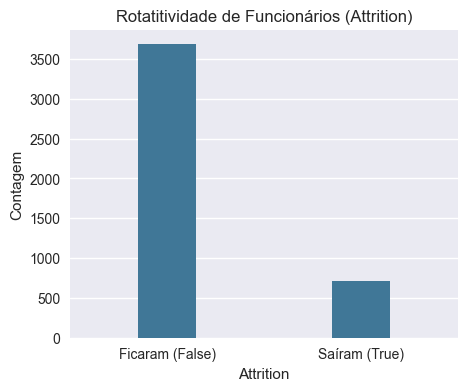

In [653]:
# Gráfico de barras do percentual de pessoas que saíram da empresa
plt.figure(figsize=(5, 4))
sns.countplot(x='Attrition', data=df, color='#327BA5', width=0.3)
plt.title('Rotatitividade de Funcionários (Attrition)')
plt.xlabel('Attrition')
plt.ylabel('Contagem')
plt.xticks(ticks=[0, 1], labels=['Ficaram (False)', 'Saíram (True)'])
plt.show()

## Boxplots para Visualizar os Outliers

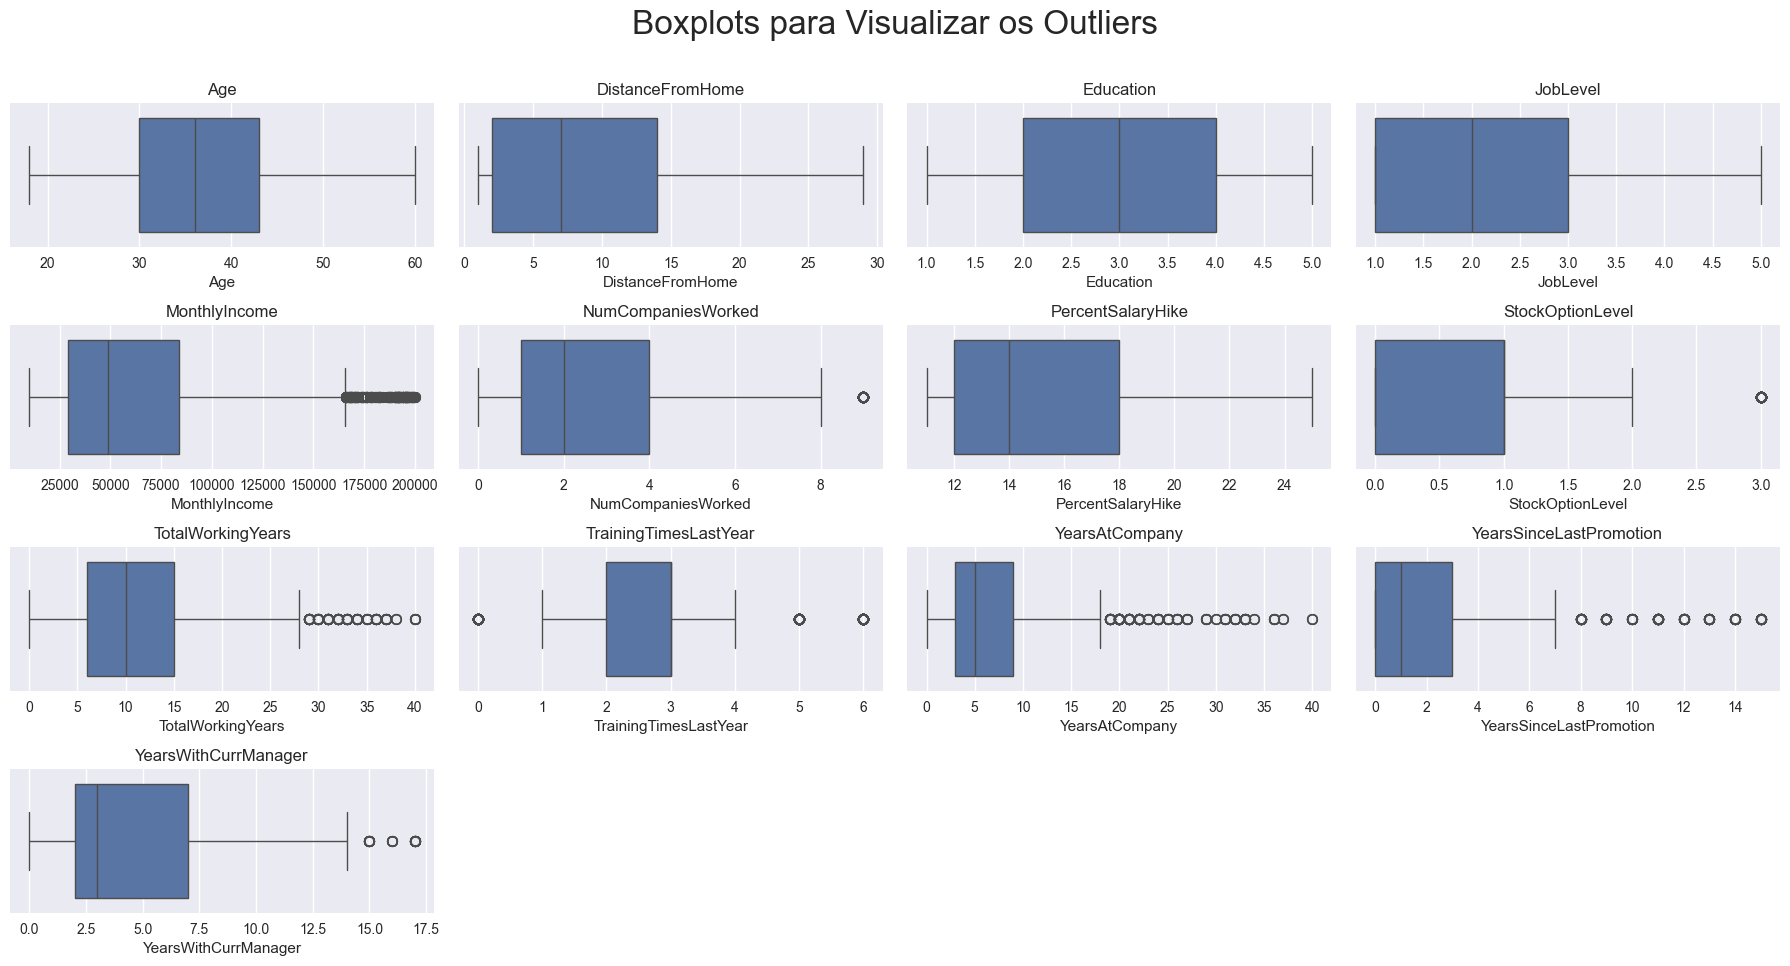

In [654]:
# Seleciona apenas colunas numéricas (exceto EmployeeID)
num_cols = df.select_dtypes(include=['int64']).columns.drop('EmployeeID')

# Define o tamanho da figura
plt.figure(figsize=(18, 12))
plt.suptitle('Boxplots para Visualizar os Outliers', fontsize=24)

# Loop para criar os subplots dos boxplots
for i, col in enumerate(num_cols):
    plt.subplot(5, 4, i + 1)
    sns.boxplot(x=col, data=df, orient='h')
    plt.title(col, fontsize=12)

plt.tight_layout(rect=[0, 0.03, 1, 0.97]) # Ajusta o layout para não sobrepor o título
plt.show()

### Análise de Distribuição e Outliers com Boxplots  

- Variáveis com Distribuição Normal e Sem Outliers Relevantes:  
`Age`, `DistanceFromHome`, `PercentSalaryHike`  
Estas variáveis apresentam uma distribuição relativamente simétrica, com a mediana próxima ao centro da caixa (IQR).  
Os outliers presentes são poucos e próximos aos limites, não indicando anomalias extremas.

- Variáveis com Assimetria à Direita e Outliers Esperados:  
`MonthlyIncome`, `TotalWorkingYears`, `YearsAtCompany`, `YearsSinceLastPromotion`  
Todas estas variáveis, ligadas à remuneração e ao tempo de serviço, apresentam uma cauda longa à direita.  
Isso é um padrão esperado em dados de RH: a maioria dos funcionários se concentra nos valores mais baixos (salários de entrada, menos tempo de casa),  
com um número menor de funcionários (geralmente executivos e sêniores) representando os outliers com valores muito altos.

- Variáveis Ordinais e de Contagem:  
`JobLevel`, `StockOptionLevel`, `NumCompaniesWorked`, `TrainingTimesLastYear`  
Estas variáveis representam contagens ou níveis. Os boxplots mostram a concentração dos dados em valores baixos.  
Por exemplo, a maioria dos funcionários está nos níveis de cargo 1 e 2, e a maioria teve entre 2 e 3 treinamentos no último ano.  

**Decisão:** Todos os outliers foram mantidos no dataset. 

Eles não representam erros de dados, mas sim casos reais e importantes para o negócio (ex: executivos com altos salários, funcionários com longa carreira).  
A remoção desses pontos poderia enviesar o modelo e comprometer sua capacidade de entender os perfis de funcionários mais experientes, que são cruciais para a retenção.

## Histogramas para Visualizar a Distribuição das Variáveis

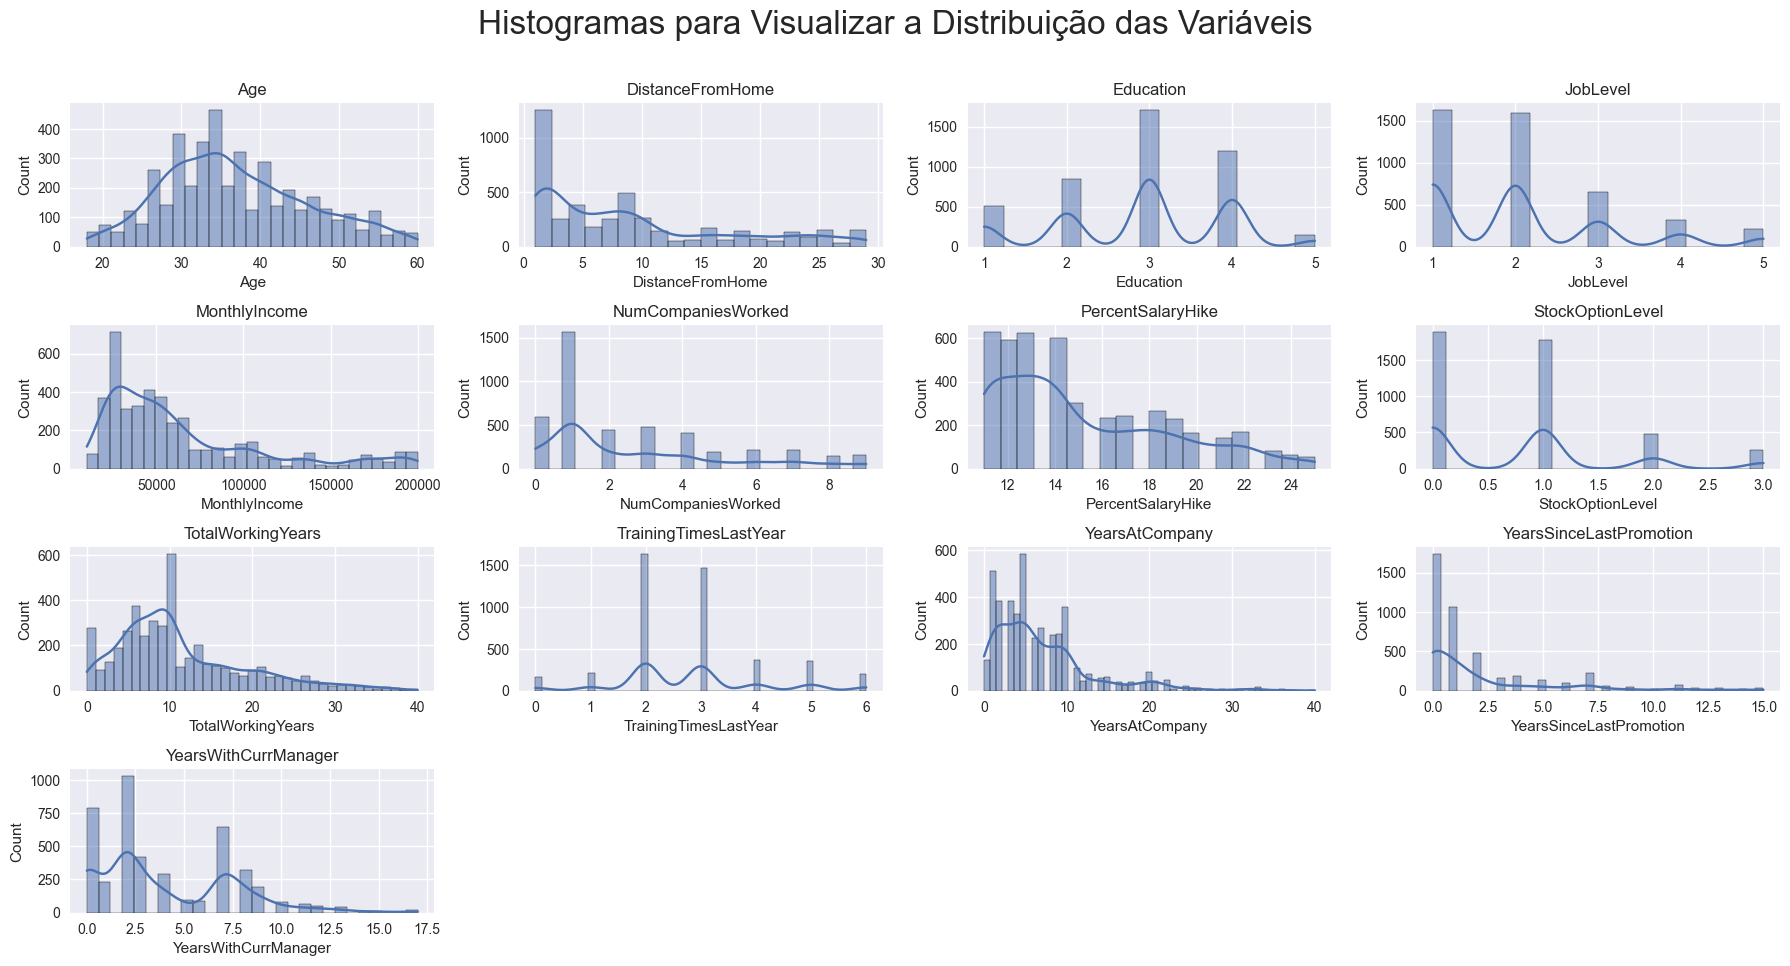

In [655]:
# Seleciona apenas colunas numéricas (exceto EmployeeID)
num_cols = df.select_dtypes(include=['int64']).columns.drop('EmployeeID')

# Define o tamanho da figura
plt.figure(figsize=(18, 12))
plt.suptitle('Histogramas para Visualizar a Distribuição das Variáveis', fontsize=24)

# Loop para criar os subplots dos histogramas
for i, col in enumerate(num_cols):
    plt.subplot(5, 4, i + 1)  # 5 linhas, 4 colunas
    sns.histplot(df[col], kde=True)
    plt.title(col, fontsize=12)

plt.tight_layout(rect=[0, 0.03, 1, 0.97]) # Ajusta o layout para não sobrepor o título
plt.show()


### Análise de Frequências com Histogramas

- **Assimetria à Direita (Right-Skewed):**  
   Variáveis como `MonthlyIncome`, `TotalWorkingYears` e `YearsAtCompany` apresentam forte assimetria à direita, com longa cauda.  
   Isso confirma o observado nos boxplots, a maioria dos funcionários possui salários mais baixos e menos tempo de casa,  
   com poucos casos de valores muito altos (funcionários sêniores).

- **Distribuições Multimodais (Múltiplos Picos):**  
   Variáveis como `Education` e `JobLevel` mostram picos distintos, refletindo sua natureza ordinal.  
   Funcionários estão concentrados em níveis específicos (ex: nível 3 de educação, níveis 1 e 2 de cargo).  
   `StockOptionLevel` também apresenta distribuição com picos nos níveis 0 e 1.

-  **Concentração em Valores Baixos:**  
   - `DistanceFromHome`: Forte concentração até 10 km, sugerindo que a maioria mora perto do trabalho.  
   - `YearsSinceLastPromotion`: Pico expressivo em 0 e 1 ano, indicando que muitos foram promovidos recentemente, ou há um grupo estagnado há vários anos.

-  **Distribuição Aproximadamente Normal:**  
   A variável `Age` se aproxima de uma distribuição normal, com concentração entre 30 e 40 anos.

**Conclusão:**  
A combinação de boxplots e histogramas aprofunda a compreensão das variáveis.  
Identifiquei os outliers como casos reais e importantes, são padrões comuns em dados de RH e e relevantes para a modelagem preditiva.


## Correlação entre as Variáveis

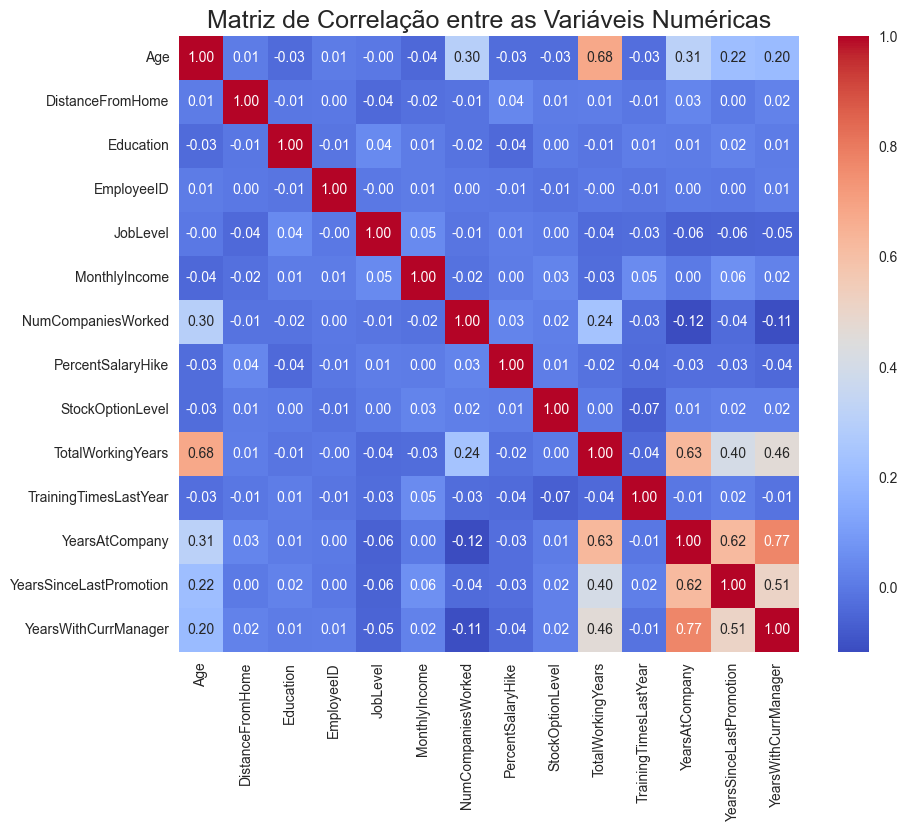

In [656]:
# Matriz de correlação entre as variáveis numéricas

# Define o tamanho da figura para 12x10 polegadas
plt.figure(figsize=(10, 8))

# Cria o mapa de calor com a matriz de correlação entre variáveis numéricas
# - numeric_only=True: considera apenas colunas numéricas
# - annot=True: exibe os valores dentro das células
# - fmt=".2f": formata os valores com 2 casas decimais
# - cmap="coolwarm": define a paleta de cores (azul a vermelho)
sns.heatmap(df.corr(numeric_only=True), annot=True, fmt=".2f", cmap="coolwarm")

# Adiciona o título ao gráfico
plt.title('Matriz de Correlação entre as Variáveis Numéricas', fontsize=18)

# Exibe o gráfico
plt.show()

A matriz de correlação (heatmap) foi utilizada para quantificar a relação linear entre as variáveis numéricas.  

1. **Correlações Positivas Fortes (Esperadas):**  
   - Correlação alta entre `YearsAtCompany` e `YearsWithCurrManager` (0.77):  
   indica que, para muitos funcionários, o tempo na empresa é semelhante ao tempo com o mesmo gestor.  
   - `TotalWorkingYears` está fortemente correlacionado com `Age` (0.68) e `YearsAtCompany` (0.63), o que é esperado.

2. **Correlações Negativas (Fracas) com a Variável Alvo (`Attrition`):**  
   - `Attrition` tem correlações negativas fracas com `TotalWorkingYears` (-0.17), `Age` (-0.16) e `YearsWithCurrManager` (-0.16).  
   - Isso sugere que funcionários com mais idade, mais experiência e mais tempo com o mesmo gestor tendem a permanecer mais tempo na empresa.

3. **Implicações para a Modelagem – Risco de Multicolinearidade:**  
   - As fortes correlações entre as variáveis de tempo (`TotalWorkingYears`, `YearsAtCompany`, `YearsWithCurrManager`, `YearsSinceLastPromotion`) e com `Age` apontam para possível **multicolinearidade**.  
   - Algoritmos como Random Forest e XGBoost lidam bem com isso, mas a interpretação da importância das features pode ser prejudicada.  
   - Exemplo: o modelo pode "dividir" a importância entre `YearsAtCompany` e `TotalWorkingYears`, dificultando entender qual é mais relevante para o churn.


## Quais características diferenciam os funcionários que saem dos que ficam?

### Análise Bivariada: Variáveis Numéricas vs. Attrition

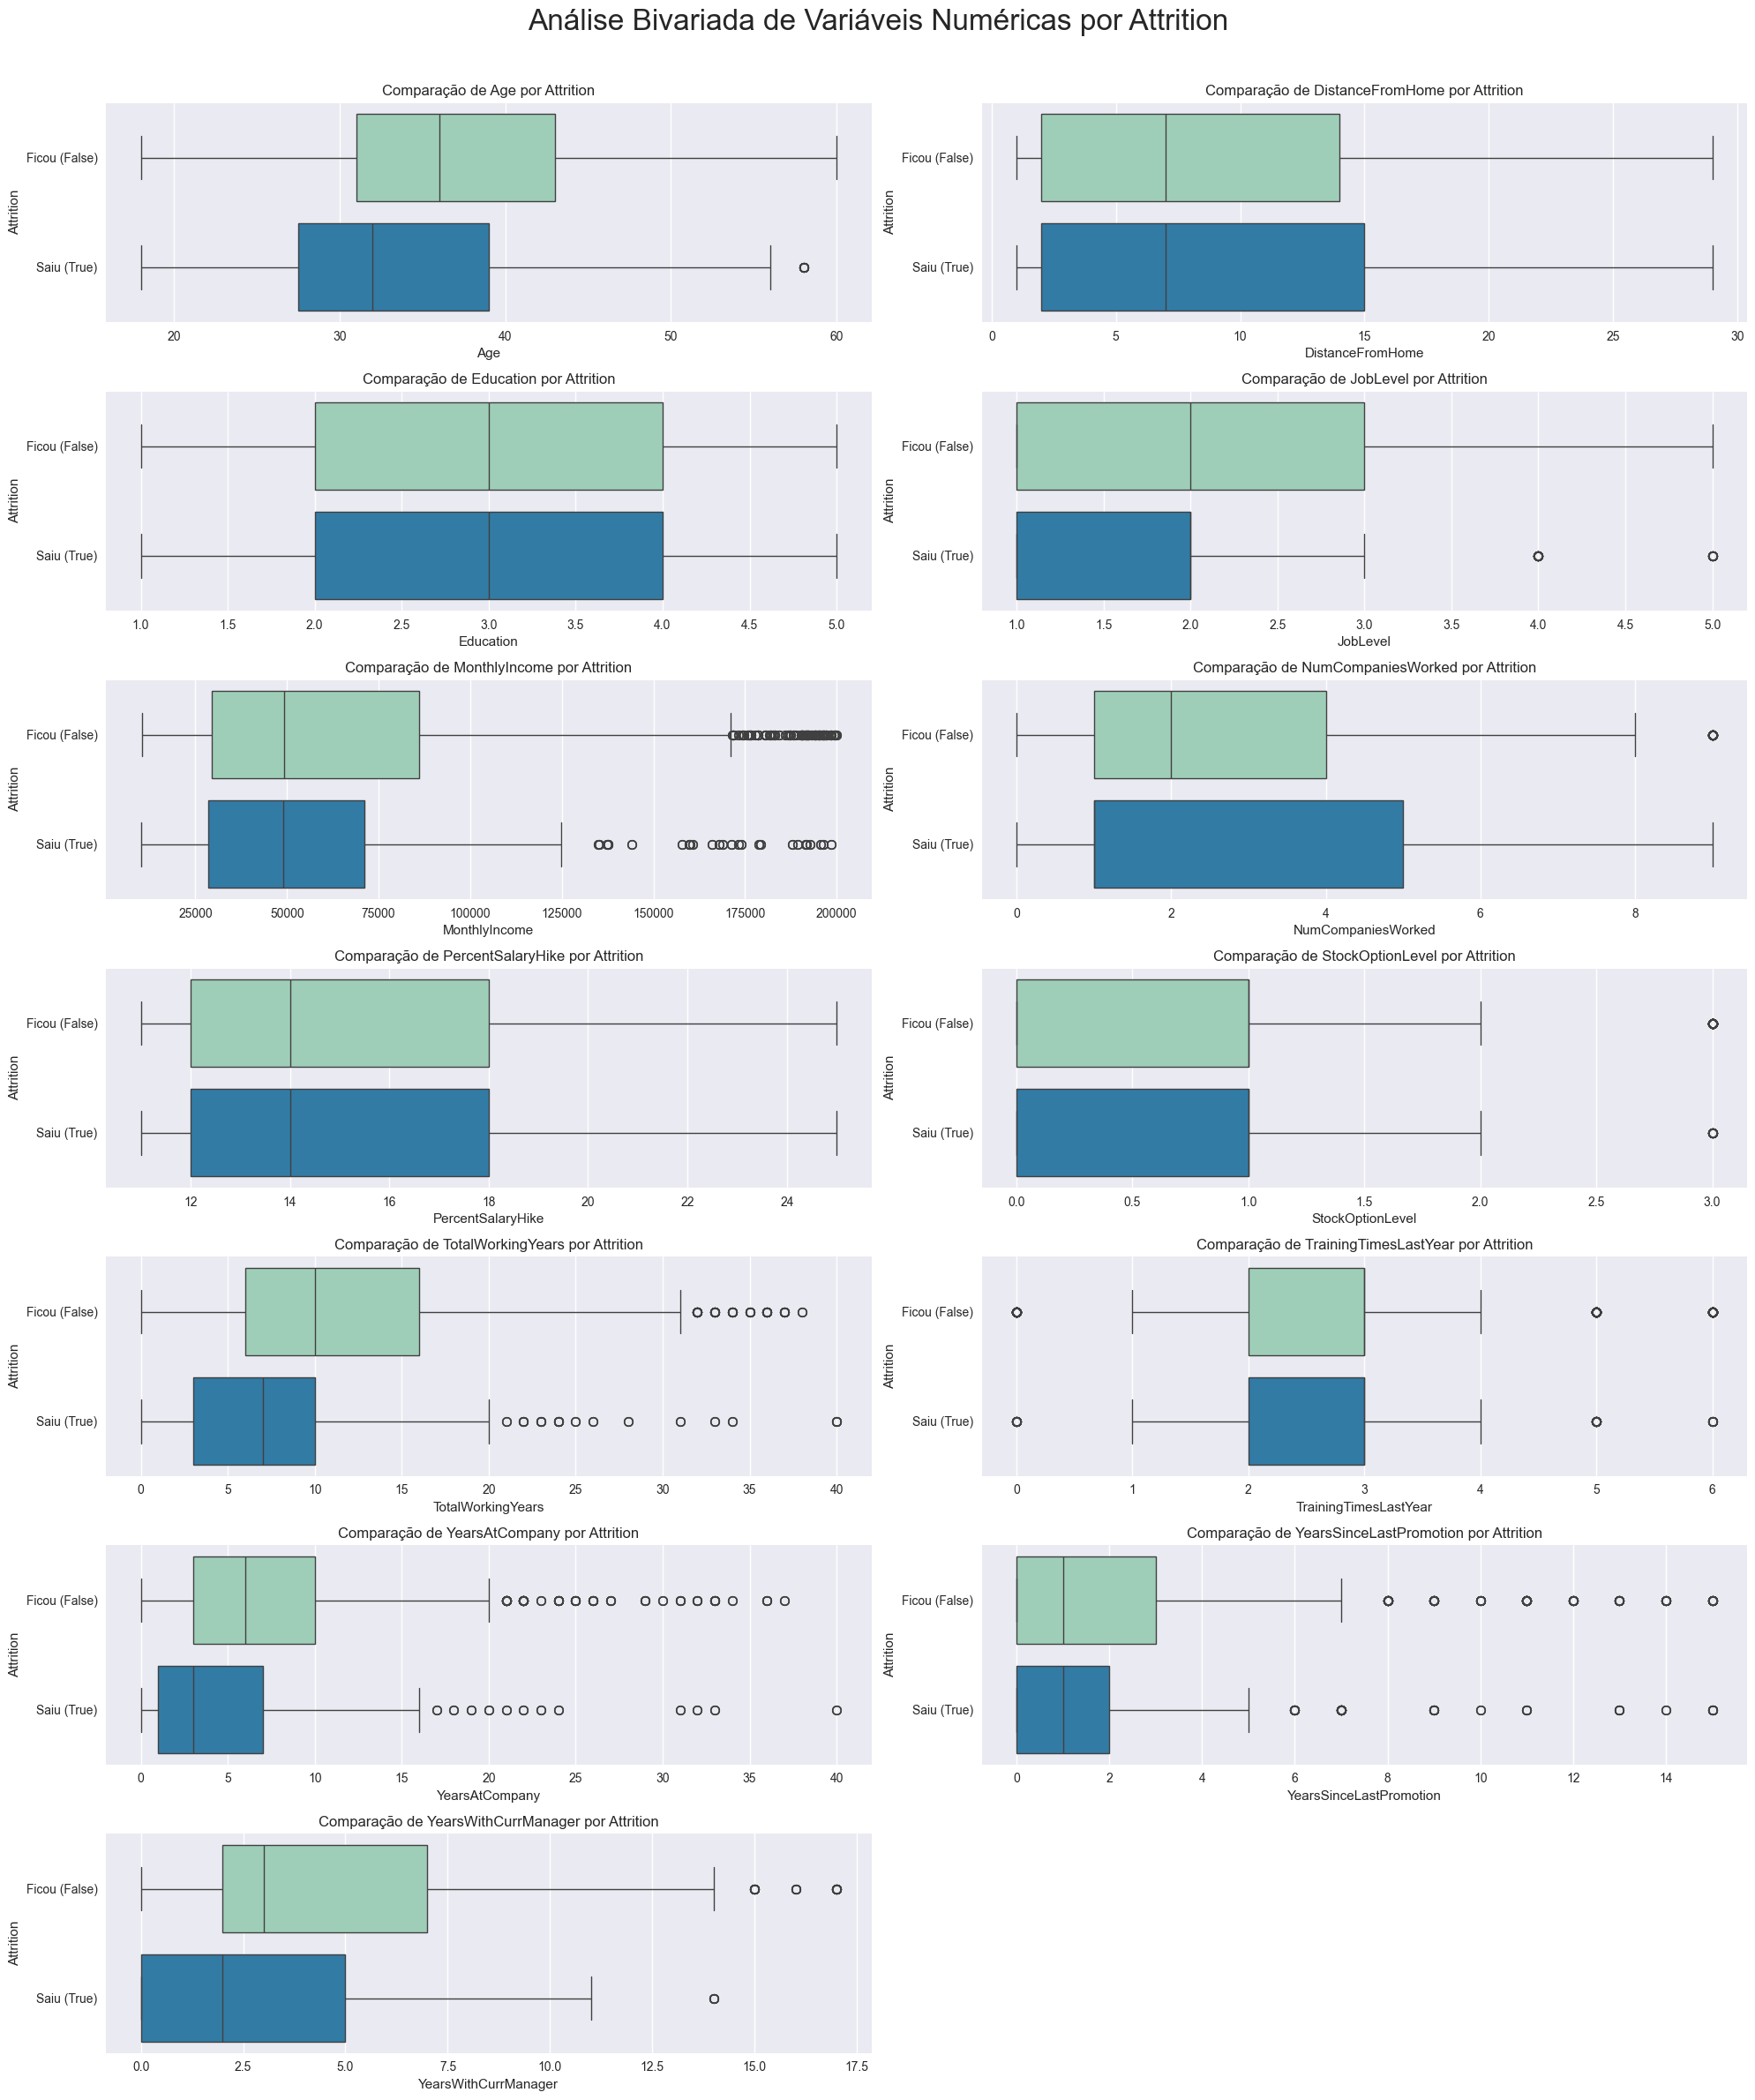

In [657]:
# Seleciona as colunas numéricas de interesse, excluindo o ID
numeric_cols = df.select_dtypes(include=['int64']).columns.drop('EmployeeID')

# Define o tamanho da figura
plt.figure(figsize=(20, 25)) # Aumentei um pouco a altura para os gráficos não ficarem apertados
plt.suptitle('Análise Bivariada de Variáveis Numéricas por Attrition', fontsize=24)

# Loop para criar os subplots
for i, col in enumerate(numeric_cols):
    # Adiciona um subplot à grade (7 linhas, 2 colunas) - mais legível
    plt.subplot(7, 2, i + 1)
    
    # Para o boxplot horizontal, trocamos x e y
    # A variável categórica 'Attrition' vai para o eixo y
    # A variável numérica 'col' vai para o eixo x
    sns.boxplot(x=col, y='Attrition', data=df, hue='Attrition', palette='YlGnBu', legend=False, orient='h')
    
    plt.title(f'Comparação de {col} por Attrition', fontsize=12)
    # Trocamos para set_yticks e set_yticklabels
    plt.yticks([0, 1], ['Ficou (False)', 'Saiu (True)']) 
    plt.ylabel('Attrition')
    plt.xlabel(col)

plt.tight_layout(rect=[0, 0.03, 1, 0.97]) # Ajusta o layout para não sobrepor o título
plt.show()

#### Análise Bivariada de Variáveis Numéricas por Attrition

Para entender as características que diferenciam os funcionários que deixam a empresa (turnover) dos que permanecem,  
foram gerados boxplots comparativos para cada variável numérica em relação à variável alvo `Attrition`.

- **Idade e Experiência (Sinal Forte):**  
Variáveis como `Age`, `TotalWorkingYears`, `YearsAtCompany` e `YearsWithCurrManager` mostram que os funcionários que saem  
tendem a ser mais jovens e com menos experiência. A mediana do grupo que "Saiu" é visivelmente menor em todas elas.

**Hipótese:** Funcionários mais jovens, menos experientes e com pouco tempo na empresa ou com o gestor atual são mais propensos a sair.

- **Remuneração e Cargo (Sinal Forte):**  
As variáveis `MonthlyIncome` e `JobLevel` indicam que funcionários que saem ocupam cargos mais baixos e têm salários menores.

**Hipótese:** Progressão de carreira e remuneração são fatores importantes para retenção.

- **Engajamento e Oportunidades (Sinal Moderado):**  
Variáveis como `NumCompaniesWorked` e `StockOptionLevel` mostram padrões relevantes.  
Quem saiu tende a ter mudado mais de empresa antes e a não possuir stock options.

**Hipótese:** Ter histórico de trocas frequentes de trabalho e não ter incentivos de longo prazo pode estar ligado à decisão de sair.

- **Variáveis com Pouca Diferença Visual:**  
Variáveis como `DistanceFromHome`, `PercentSalaryHike` e `TrainingTimesLastYear` não apresentam diferença clara entre os grupos.

**Hipótese:** Sozinhas, essas variáveis têm pouco poder explicativo. Podem ganhar relevância em combinação com outras no modelo.


### Análise de Variáveis Categóticas vs. Attrition

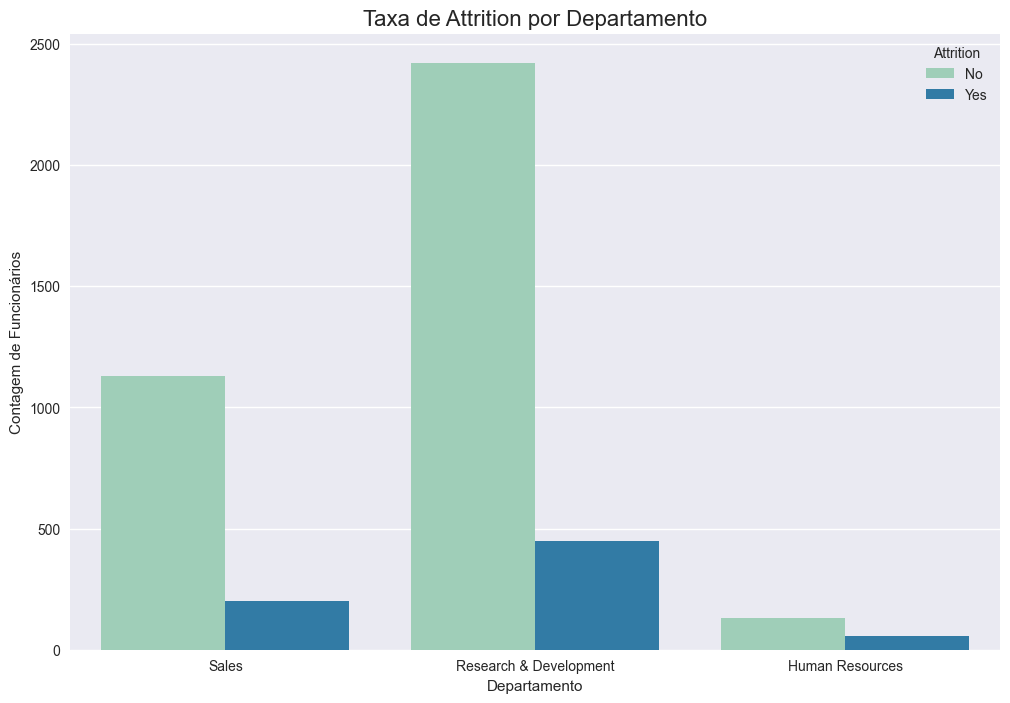

In [658]:
# --- Attrition por Departamento ---
plt.figure(figsize=(12, 8))
sns.countplot(x='Department', hue='Attrition', data=df, palette='YlGnBu')
plt.title('Taxa de Attrition por Departamento', fontsize=16)
plt.ylabel('Contagem de Funcionários')
plt.xlabel('Departamento')
plt.show()

#### Taxa de Attrition por Departamento

O departamento de Pesquisa e Desenvolvimento (Research & Development) possui o maior número absoluto de funcionários e,  
consequentemente, o maior número absoluto de saídas.

No entanto, ao analisar a proporção de saídas em relação ao total de cada departamento,  
os departamentos de Vendas (Sales) e Recursos Humanos (Human Resources) apresentam uma taxa de churn visualmente maior.  

O departamento de RH, em particular, parece ter a maior taxa proporcional de saídas.

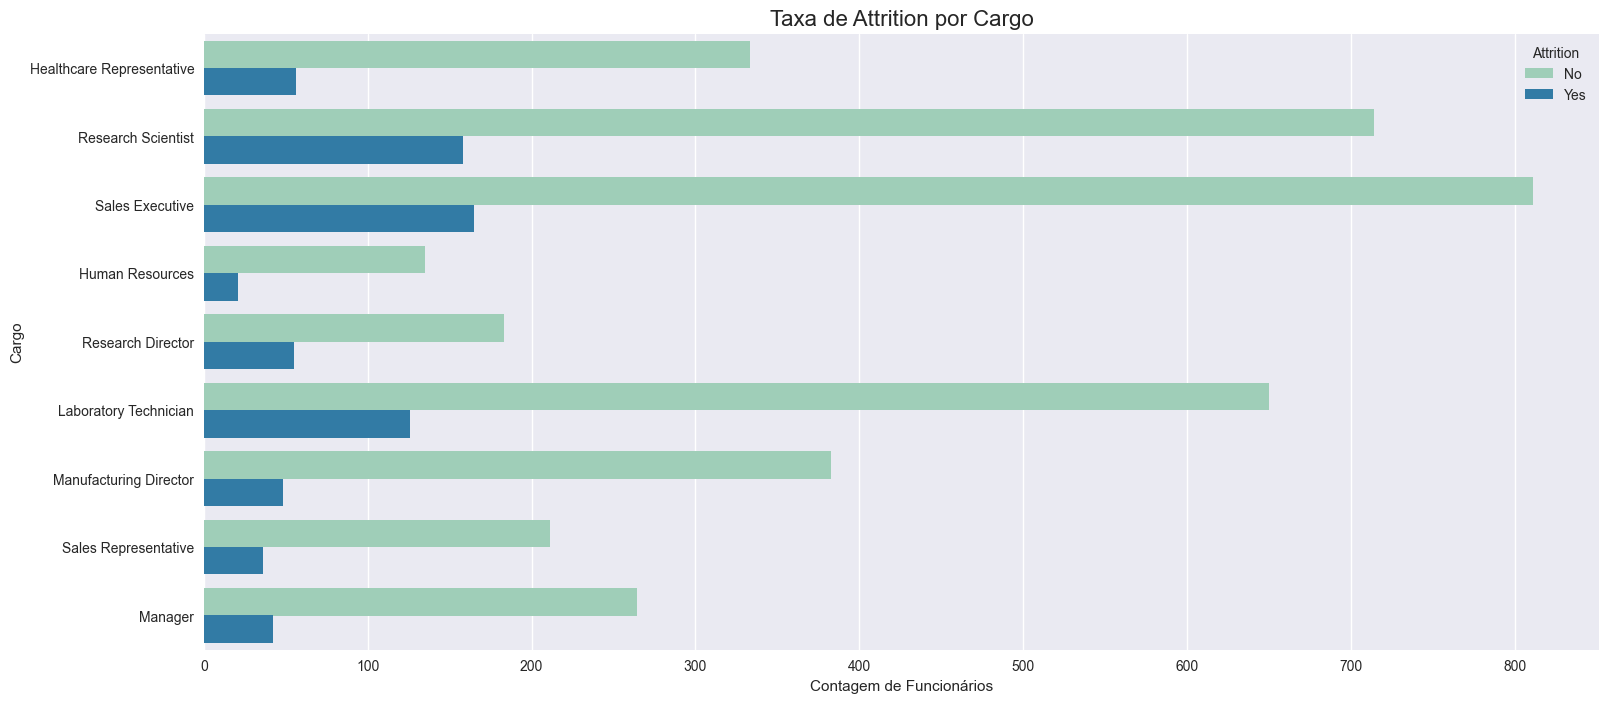

In [659]:
# --- Attrition por Cargo (JobRole) ---
plt.figure(figsize=(18, 8))
sns.countplot(y='JobRole', hue='Attrition', data=df, palette='YlGnBu')
plt.title('Taxa de Attrition por Cargo', fontsize=16)
plt.xlabel('Contagem de Funcionários')
plt.ylabel('Cargo')
plt.show()

#### Taxa de Attrition por Cargo (JobRole)

A análise por cargo revela padrões muito distintos.

- Cargos de Alta Rotatividade: Cargos como Laboratory Technician, Sales Representative e Human Resources  
mostram uma proporção significativamente alta de churn (barras azuis grandes em relação às verdes).

- Cargos de Baixa Rotatividade: Por outro lado, cargos de liderança ou maior senioridade,  
como Manager, Research Director e Manufacturing Director, exibem uma taxa de saída muito baixa, indicando alta retenção.

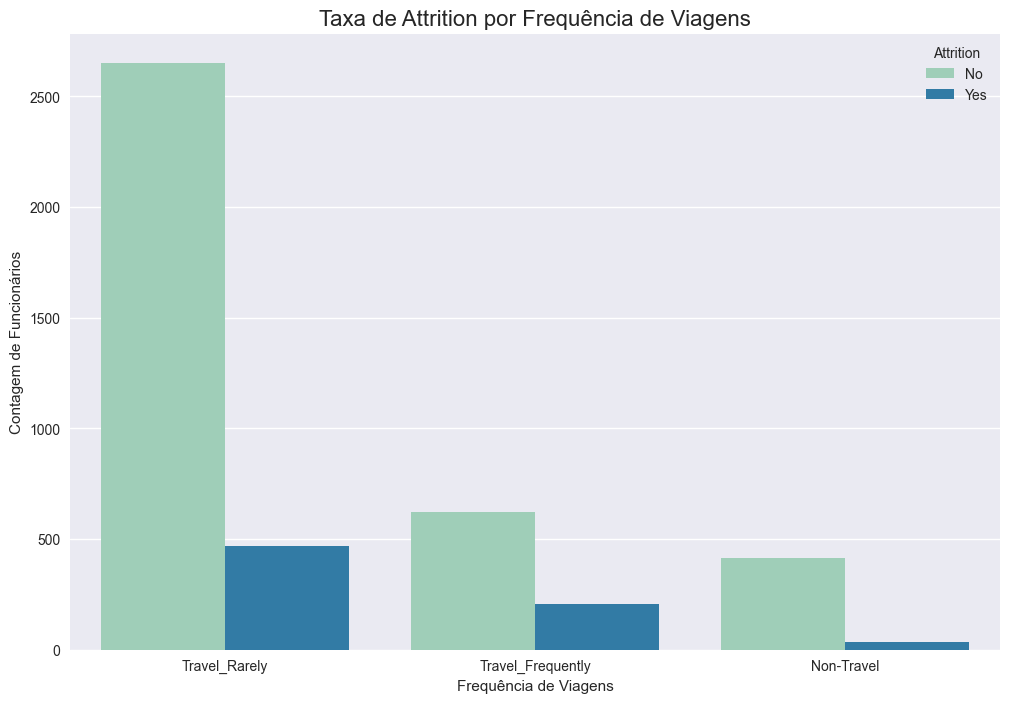

In [660]:
# --- Attrition por Viagens a Negócio (BusinessTravel) ---
plt.figure(figsize=(12, 8))
sns.countplot(x='BusinessTravel', hue='Attrition', data=df, palette='YlGnBu')
plt.title('Taxa de Attrition por Frequência de Viagens', fontsize=16)
plt.ylabel('Contagem de Funcionários')
plt.xlabel('Frequência de Viagens')
plt.show()

#### Taxa de Attrition por Frequência de Viagens (BusinessTravel)

Há uma correlação muito clara entre a frequência de viagens e a probabilidade de um funcionário sair.

A categoria Travel_Frequently (viaja frequentemente) possui, de longe, a maior taxa de rotatividade proporcional.  
Em contraste, a categoria Non-Travel (não viaja) apresenta a menor taxa de saída, com uma barra de churn quase insignificante.

#### Conclusão da Análise Categórica

Fatores como o cargo, a frequência de viagens e o departamento são preditores muito fortes da rotatividade.  

O perfil com maior risco parece ser o de funcionários em cargos mais operacionais (Técnico de Laboratório e Representante de Vendas),  
que viajam com frequência, especialmente nos departamentos de Vendas e RH.

# Feature Engineering

Para treinar o modelo, criarei as variáveis dummy.  
Porém, antes disso, é preciso excluir variáveis que são altamente relacionadas ou que podem introduzir viés na análise.

Variáveis excluídas:

- `Gender` e `MaritalStatus`: removidas por não apresentarem correlação relevante com a variável alvo (Attrition)  
e por potencial risco de introdução de viés (bias), especialmente no caso de Gender.

- `EducationField`: eliminada por apresentar sobreposição conceitual e alta similaridade com JobRole,  
que será mantida por agregar mais valor à análise funcional do colaborador.

- `EmployeeID`: excluída pois é o identificador do funcionário.

Depois, criar variáveis dummy: `Department`, `BusinessTravel` e `JobRole`

## Excluindo as variáveis que não são relevantes para o modelo

In [661]:
# Excluindo colunas que não serão utilizadas no modelo
cols_to_drop = ['EmployeeID', 'Gender', 'MaritalStatus', 'EducationField']
df_model = df.drop(columns=cols_to_drop, axis=1)

# Preparação dos Dados para o Modelo

## Pré-Processamento dos Dados

Nesta etapa, foram realizadas as seguintes ações para preparar os dados para a modelagem preditiva:

- **Definição da variável alvo (`y`)**: a coluna `Attrition`, que indica se o colaborador saiu (1) ou permaneceu (0) na empresa.
- **Separação das variáveis preditoras (`X`)**: todas as demais colunas, exceto `Attrition`.
- **Codificação de variáveis categóricas**: foi aplicado `pd.get_dummies()` apenas nas colunas categóricas de `X`,  
utilizando o parâmetro `drop_first=True` para evitar multicolinearidade.

Essas transformações garantem que os dados estejam em formato numérico e compatíveis com os algoritmos de machine learning utilizados nas etapas seguintes.
Antes de realizar a transformação das variáveis categóricas em dummies, separei a variável Attrition,  
que é a variável alvo do modelo, das demais variáveis independentes. 

A separação da variável alvo é uma etapa essencial, pois, ao criar as variáveis dummies,  
a variável alvo não deve ser incluída no processo, já que ela será utilizada para treinar e avaliar o modelo.

Após essa separação, as variáveis independentes restantes foram convertidas para variáveis dummies (One-Hot Encoding),  
transformando as variáveis categóricas em novas colunas binárias.

Isso permite que o modelo de machine learning entenda essas variáveis e possa utilizar para prever a variável Attrition.

In [662]:
# A variável alvo é 'Attrition', mas está como texto ("Yes"/"No") - ("True"/"False")
# O primeiro passo é converter para booleana
df_model['Attrition'] = df_model['Attrition'].map({'Yes': 1, 'No': 0}).astype(int)
# Verificando os tipos de dados novamente
df_model.info()

<class 'pandas.core.frame.DataFrame'>
Index: 4391 entries, 0 to 4409
Data columns (total 17 columns):
 #   Column                   Non-Null Count  Dtype 
---  ------                   --------------  ----- 
 0   Age                      4391 non-null   int64 
 1   Attrition                4391 non-null   int64 
 2   BusinessTravel           4391 non-null   object
 3   Department               4391 non-null   object
 4   DistanceFromHome         4391 non-null   int64 
 5   Education                4391 non-null   int64 
 6   JobLevel                 4391 non-null   int64 
 7   JobRole                  4391 non-null   object
 8   MonthlyIncome            4391 non-null   int64 
 9   NumCompaniesWorked       4391 non-null   int64 
 10  PercentSalaryHike        4391 non-null   int64 
 11  StockOptionLevel         4391 non-null   int64 
 12  TotalWorkingYears        4391 non-null   int64 
 13  TrainingTimesLastYear    4391 non-null   int64 
 14  YearsAtCompany           4391 non-null   int6

## Variável Alvo e Preditoras (com criação das dummy)

In [663]:
# Separando a variável-alvo antes de criar as dummies
df = df_model.drop(columns='Attrition') # variáveis preditoras ou features
y = df_model['Attrition'] # variável alvo

X = df

# Convertendo variáveis categóricas em variáveis dummy (one-hot encoding)
X = pd.get_dummies(X, drop_first=True)

## Divisão do Conjunto de Dados (Train/Test Split)

Antes de treinar o modelo, dividimos os dados em conjunto de treino e teste.  
Para isso, usamos a função train_test_split do sklearn, com as seguintes configurações:

- **Tamanho do Conjunto de Teste:** 30% dos dados foram destinados ao conjunto de teste (test_size=0.3),  
o que permite que o modelo seja avaliado com uma boa quantidade de dados não vistos.

- **Random State:** A configuração random_state=42 foi usada para garantir a reprodutibilidade da divisão.  
Isso significa que, sempre que rodarmos o código, a divisão dos dados será a mesma, facilitando a comparação dos resultados.

- **Stratify:** Ao usar Stratify=y, garantimos que a distribuição da variável alvo Attrition seja mantida de forma proporcional  
tanto no conjunto de treino quanto no de teste. Isso é importante em problemas de classificação desbalanceada,  
como o caso da rotatividade de funcionários, onde a maioria dos funcionários não saem da empresa.

In [664]:
# dividindo os dados em treino e teste
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

# Modelagem Preditiva (XGBoost)

## Criando o Modelo XGBoost Base

In [665]:
# Criando o modelo XGBoost Base
xgb_model = xgb.XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)

### Validação Cruzada

A validação cruzada garante que o modelo seja testado em diferentes divisões dos dados,  
evitando que a avaliação dependa de uma única amostra.

Usei a técnica Stratified K-Fold para manter o equilíbrio da variável de saída em todas as divisões,  
já que os dados estão desbalanceados.

In [666]:
# cross_validate: realiza a validação cruzada
# StratifiedKFold: garante que a proporção de classes seja mantida em cada fold
cv_strategy = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# score: calcula as métricas de avaliação
scoring_metrics = ['accuracy', 'precision', 'recall', 'f1', 'roc_auc']
results = cross_validate(xgb_model, X_train, y_train, cv=cv_strategy, scoring=scoring_metrics, return_train_score=False)


#### Resultados da Validação Cruzada

In [667]:
print("Resultados da Validação Cruzada (Desempenho no Treino XGBoost):")
for metric in scoring_metrics:
    mean_score = results[f'test_{metric}'].mean()
    std_score = results[f'test_{metric}'].std()
    print(f"  - {metric.capitalize()}: ({mean_score:.4f} (+/- {std_score:.4f})")

Resultados da Validação Cruzada (Desempenho no Treino XGBoost):
  - Accuracy: (0.9574 (+/- 0.0062)
  - Precision: (0.9205 (+/- 0.0282)
  - Recall: (0.8061 (+/- 0.0346)
  - F1: (0.8588 (+/- 0.0218)
  - Roc_auc: (0.9486 (+/- 0.0150)


#### Validação Cruzada - Avaliação do Desempenho no Treinamento

A validação cruzada com `StratifiedKFold` (5 folds) foi utilizada para garantir uma avaliação robusta e evitar overfitting,  
mantendo a proporção da variável alvo em cada partição.  

Os resultados mostram que o modelo apresenta desempenho sólido e estável:

- **Acurácia**: alta taxa de acertos gerais.
- **Precisão**: poucos falsos positivos (quando o modelo prevê que alguém vai sair, geralmente está certo).
- **Recall**: boa capacidade de identificar os funcionários que realmente saem.
- **F1-score**: equilíbrio entre precisão e recall.
- **ROC AUC**: excelente separação entre as classes (sair ou ficar).

A baixa variação entre os folds (+/-) reforça a estabilidade do modelo.

## Treinando o Modelo

In [668]:
# Treinando o modelo
xgb_model.fit(X_train, y_train)

# Fazendo previsões no conjunto de teste
y_pred = xgb_model.predict(X_test)

## Avaliação do Modelo Base


Resultados da Avaliação do Modelo XGBoost Base:
  - Acurácia: 0.9825
  - Precisão: 0.9479
  - Recall: 0.9434
  - F1-Score: 0.9456
  - ROC AUC: 0.9707
--------------------------------------------------
Verdadeiros Negativos (VN): 1095
Falsos Positivos (FP): 11
Falsos Negativos (FN): 12
Verdadeiros Positivos (VP): 200
--------------------------------------------------


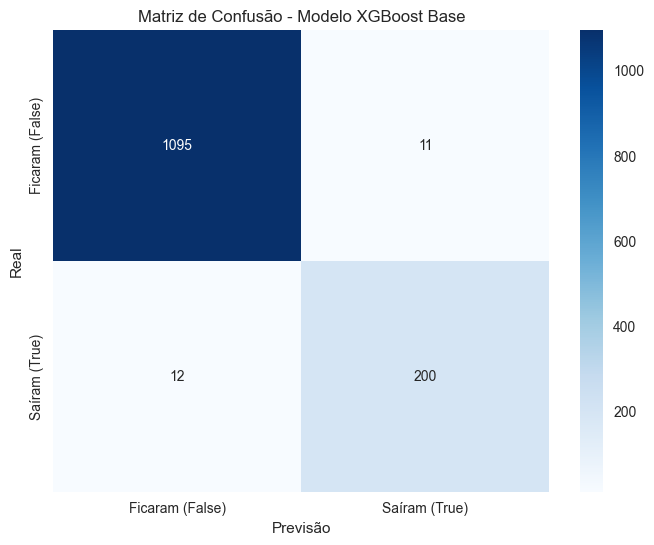


Relatório de Classificação:
                 precision    recall  f1-score   support

Ficaram (False)       0.99      0.99      0.99      1106
  Saíram (True)       0.95      0.94      0.95       212

       accuracy                           0.98      1318
      macro avg       0.97      0.97      0.97      1318
   weighted avg       0.98      0.98      0.98      1318



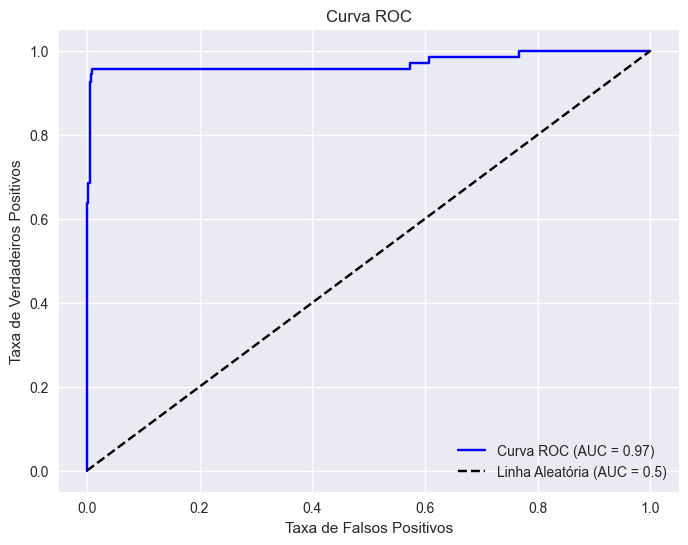

In [669]:
# Avaliando o modelo
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, xgb_model.predict_proba(X_test)[:, 1])

print("\nResultados da Avaliação do Modelo XGBoost Base:")
print(f"  - Acurácia: {accuracy:.4f}")
print(f"  - Precisão: {precision:.4f}")
print(f"  - Recall: {recall:.4f}")
print(f"  - F1-Score: {f1:.4f}")
print(f"  - ROC AUC: {roc_auc:.4f}")
print("-" * 50)
# Matriz de confusão
cm = confusion_matrix(y_test, y_pred)

# Atribui os valores
vn, fp, fn, vp = cm.ravel()

# Exibe os resultados
print(f"Verdadeiros Negativos (VN): {vn}")
print(f"Falsos Positivos (FP): {fp}")
print(f"Falsos Negativos (FN): {fn}")
print(f"Verdadeiros Positivos (VP): {vp}")
print("-" * 50)

# Matriz de confusão
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Ficaram (False)', 'Saíram (True)'], yticklabels=['Ficaram (False)', 'Saíram (True)'])
plt.title('Matriz de Confusão - Modelo XGBoost Base')
plt.xlabel('Previsão')
plt.ylabel('Real')
plt.show()

# Relatório de classificação
print("\nRelatório de Classificação:")
print(classification_report(y_test, y_pred, target_names=['Ficaram (False)', 'Saíram (True)']))

# Curva ROC
fpr, tpr, thresholds = roc_curve(y_test, xgb_model.predict_proba(X_test)[:, 1])
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label='Curva ROC (AUC = {:.2f})'.format(roc_auc), color='blue')
plt.plot([0, 1], [0, 1], 'k--', label='Linha Aleatória (AUC = 0.5)')
plt.title('Curva ROC')
plt.xlabel('Taxa de Falsos Positivos')
plt.ylabel('Taxa de Verdadeiros Positivos')
plt.legend()
plt.show()


## Otimização: Ajuste de Hiperparâmetros

In [670]:
# Otimização de hiperparâmetros com GridSearchCV
param_grid = {
'max_depth': [3, 4, 6], # Profundidade da árvore
'learning_rate': [0.05, 0.1, 0.2], # Taxa de aprendizado
'n_estimators': [200, 300, 400], # Número de árvores
'gamma': [0.1, 0.5, 1], # Regularização (maior = mais conservador)
'subsample': [0.8, 1.0], # Amostragem de dados
'colsample_bytree': [0.8, 1.0] # Amostragem de colunas
}

# Configurando a estratégia de validação cruzada
grid_search = GridSearchCV(
estimator=xgb_model, # modelo XGBoost base
param_grid=param_grid,
scoring='f1', # Otimizando para o F1-Score, um bom equilíbrio
cv=cv_strategy, # StratifiedKFold
n_jobs=-1, # Usa todos os processadores para acelerar
verbose=2 # Mostra o progresso da busca
)

# Executando a busca em grade
# Isso pode levar algum tempo dependendo do tamanho do conjunto de dados e da complexidade do modelo
grid_search.fit(X_train, y_train)

# Exibindo os melhores parâmetros encontrados
print("Melhores parâmetros encontrados:")
print(grid_search.best_params_)

# Exibindo o melhor score (F1-Score) encontrado
print(f"Melhor F1-Score: {grid_search.best_score_:.4f}")
best_xgb_model_optimized = grid_search.best_estimator_

Fitting 5 folds for each of 324 candidates, totalling 1620 fits
Melhores parâmetros encontrados:
{'colsample_bytree': 0.8, 'gamma': 0.1, 'learning_rate': 0.2, 'max_depth': 6, 'n_estimators': 200, 'subsample': 0.8}
Melhor F1-Score: 0.8778


### Ajuste Fino na Regularização

In [671]:
# Agora que temos um modelo otimizado, vamos fazer um ajuste fino focando em regularização
# Cópia do modelo otimizado para o ajuste fino
xgb_model_stage2 = xgb.XGBClassifier(
use_label_encoder=False,
eval_metric='logloss',
random_state=42,

# Parâmetros otimizados da primeira busca:
colsample_bytree=1.0,
gamma=0.1,
learning_rate=0.05,
max_depth=6,
n_estimators=400,
subsample=0.8
)

# Novo grid de parâmetros focando em regularização
# Vamos explorar a regularização L1 (reg_alpha) e L2 (reg_lambda)
param_grid_regularization = {
'reg_alpha': [0, 0.001, 0.005, 0.01, 0.05, 0.1], # Regularização L1
'reg_lambda': [0.5, 1, 1.5, 2] # Regularização L2
}

# Configurando a estratégia de validação cruzada
grid_search_regularization = GridSearchCV(
estimator=xgb_model_stage2,
param_grid=param_grid_regularization,
scoring='f1',
cv=cv_strategy,
n_jobs=-1,
verbose=1
)

# Executando a busca em grade para regularização
grid_search_regularization.fit(X_train, y_train)
print("Melhores parâmetros de regularização encontrados:")
print(grid_search_regularization.best_params_)

# Exibindo o melhor score (F1-Score) encontrado após o ajuste fino
print(f"\nMelhor F1-Score FINAL (após ajuste fino): {grid_search_regularization.best_score_:.4f}")
print("-" * 50)

# Avaliando o modelo otimizado com os melhores parâmetros de regularização
# Modelo final e otimizado salvo em uma variável
final_xgb_model = grid_search_regularization.best_estimator_
print("Modelo final otimizado:")
print(final_xgb_model)

Fitting 5 folds for each of 24 candidates, totalling 120 fits
Melhores parâmetros de regularização encontrados:
{'reg_alpha': 0.1, 'reg_lambda': 0.5}

Melhor F1-Score FINAL (após ajuste fino): 0.8735
--------------------------------------------------
Modelo final otimizado:
XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=1.0, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, feature_weights=None, gamma=0.1,
              grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.05, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=6, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=400, n_jobs=

## Avaliação do Modelo Otimizado


Resultados da Avaliação do Modelo XGBoost Otimizado:
  - Acurácia: 0.9886
  - Precisão: 0.9713
  - Recall: 0.9575
  - F1-Score: 0.9644
  - ROC AUC: 0.9747
--------------------------------------------------
Verdadeiros Negativos (VN): 1100
Falsos Positivos (FP): 6
Falsos Negativos (FN): 9
Verdadeiros Positivos (VP): 203
--------------------------------------------------


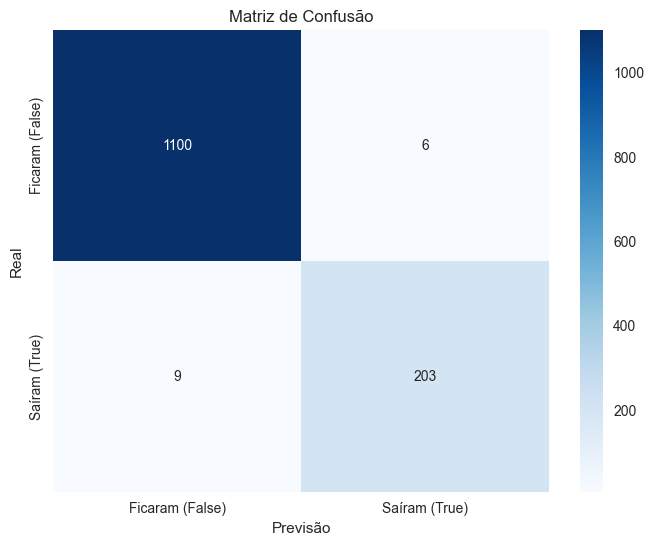


Relatório de Classificação:
                 precision    recall  f1-score   support

Ficaram (False)       0.99      0.99      0.99      1106
  Saíram (True)       0.97      0.96      0.96       212

       accuracy                           0.99      1318
      macro avg       0.98      0.98      0.98      1318
   weighted avg       0.99      0.99      0.99      1318



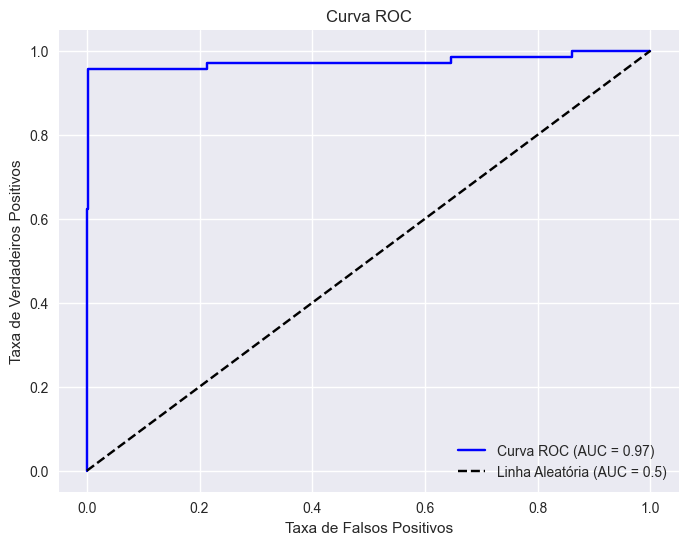

In [672]:
final_xgb_model = grid_search_regularization.best_estimator_

# Treina o modelo otimizado no conjunto de treino
final_xgb_model.fit(X_train, y_train)

# Faz previsões com o modelo otimizado
y_pred_opt = final_xgb_model.predict(X_test)
y_proba_opt = final_xgb_model.predict_proba(X_test)[:, 1]

# Avalia usando as previsões do modelo otimizado
accuracy = accuracy_score(y_test, y_pred_opt)
precision = precision_score(y_test, y_pred_opt)
recall = recall_score(y_test, y_pred_opt)
f1 = f1_score(y_test, y_pred_opt)
roc_auc = roc_auc_score(y_test, y_proba_opt)

print("\nResultados da Avaliação do Modelo XGBoost Otimizado:")
print(f"  - Acurácia: {accuracy:.4f}")
print(f"  - Precisão: {precision:.4f}")
print(f"  - Recall: {recall:.4f}")
print(f"  - F1-Score: {f1:.4f}")
print(f"  - ROC AUC: {roc_auc:.4f}")
print("-" * 50)

# Matriz de confusão
cm = confusion_matrix(y_test, y_pred_opt)
vn, fp, fn, vp = cm.ravel()
print(f"Verdadeiros Negativos (VN): {vn}")
print(f"Falsos Positivos (FP): {fp}")
print(f"Falsos Negativos (FN): {fn}")
print(f"Verdadeiros Positivos (VP): {vp}")
print("-" * 50)

# Plot matriz de confusão
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Ficaram (False)', 'Saíram (True)'],
            yticklabels=['Ficaram (False)', 'Saíram (True)'])
plt.title('Matriz de Confusão')
plt.xlabel('Previsão')
plt.ylabel('Real')
plt.show()

# Relatório de classificação
print("\nRelatório de Classificação:")
print(classification_report(y_test, y_pred_opt, target_names=['Ficaram (False)', 'Saíram (True)']))

# Curva ROC
fpr, tpr, thresholds = roc_curve(y_test, y_proba_opt)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'Curva ROC (AUC = {roc_auc:.2f})', color='blue')
plt.plot([0, 1], [0, 1], 'k--', label='Linha Aleatória (AUC = 0.5)')
plt.title('Curva ROC')
plt.xlabel('Taxa de Falsos Positivos')
plt.ylabel('Taxa de Verdadeiros Positivos')
plt.legend()
plt.show()


## Importância das variáveis

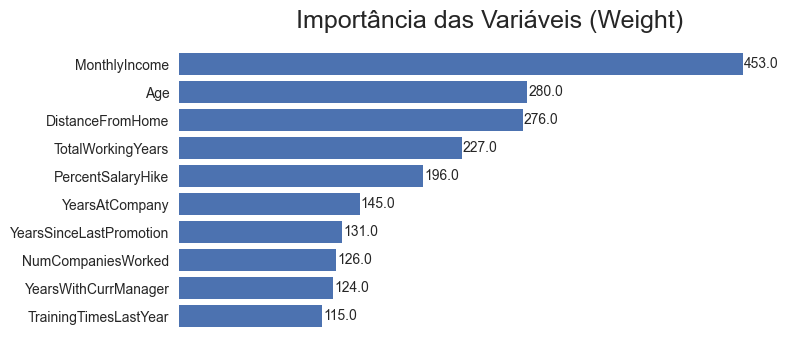

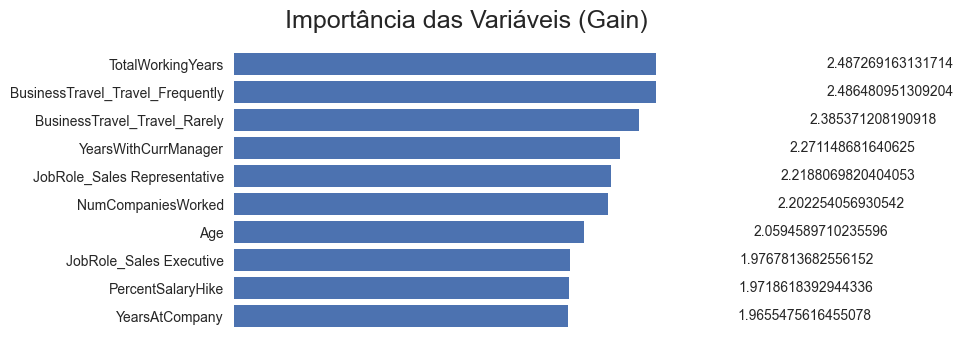

In [673]:
# Importância das variáveis
#plt.figure(figsize=(20, 10))
fig, ax = plt.subplots(figsize=(8, 4))

# weight é o número de vezes que a variável foi usada para dividir os dados
xgb.plot_importance(xgb_model, importance_type='weight', max_num_features=10, height=0.8, ax=ax)
plt.xlabel('')  # Remove o título do eixo X
plt.ylabel('')  # Remove o título do eixo Y
plt.xticks([])  # Remove os valores do eixo X
ax.set_facecolor('white')
plt.title("Importância das Variáveis (Weight)", fontsize=18)  # Tamanho da fonte do título

plt.show()

# Importância das variáveis
#plt.figure(figsize=(20, 10))
fig, ax = plt.subplots(figsize=(6, 4))

# weight é o número de vezes que a variável foi usada para dividir os dados
xgb.plot_importance(xgb_model, importance_type='gain', max_num_features=10, height=0.8, ax=ax)
plt.xlabel('')  # Remove o título do eixo X
plt.ylabel('')  # Remove o título do eixo Y
plt.xticks([])  # Remove os valores do eixo X
ax.set_facecolor('white')
plt.title("Importância das Variáveis (Gain)", fontsize=18)  # Tamanho da fonte do título

plt.show()


## Curva de Aprendizagem

A curva de aprendizagem permite visualizar como o desempenho do modelo evolui à medida que aumentamos o tamanho do conjunto de treinamento.  
Ela apresenta a pontuação (neste caso, F1-score) tanto no conjunto de treinamento quanto no conjunto de validação (via cross-validation).

Essa curva é útil para diagnosticar:

- Overfitting: quando o score de treino é alto, mas o score de validação é significativamente mais baixo.

- Underfitting: quando tanto o score de treino quanto o de validação são baixos.

- Bom ajuste: quando os scores de treino e validação são altos e próximos.

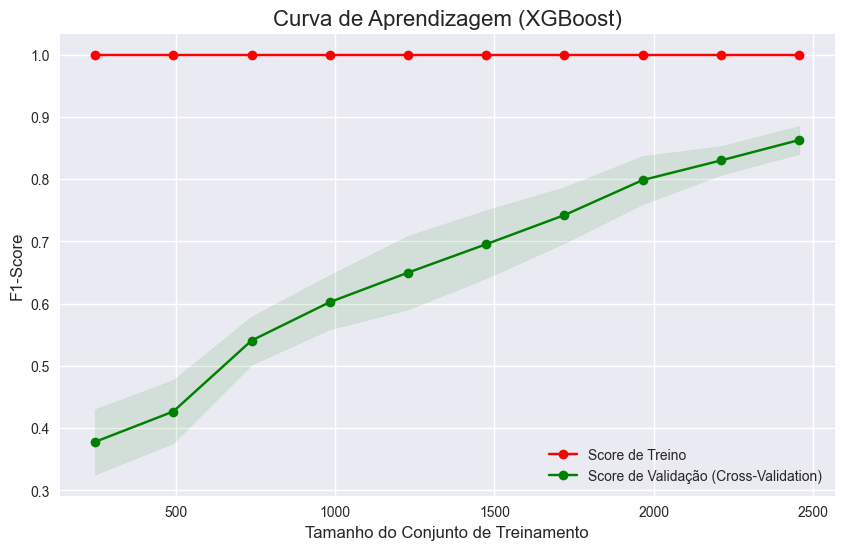

In [674]:

# Calcula os pontos para a curva de aprendizagem
train_sizes, train_scores, validation_scores = learning_curve(
    estimator=xgb_model,
    X=X_train,
    y=y_train,
    train_sizes=np.linspace(0.1, 1.0, 10), # Gera 10 pontos de 10% a 100% do treino
    cv=cv_strategy, # mesmo modelo e estratégia de CV já definido
    scoring='f1', # métrica que faz mais sentido (F1 é ótimo para desbalanceamento)
    n_jobs=-1,
    random_state=42
)

# Calcula as médias e desvios padrão para plotagem
train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
validation_scores_mean = np.mean(validation_scores, axis=1)
validation_scores_std = np.std(validation_scores, axis=1)

# Plotando o gráfico
plt.style.use('seaborn-v0_8')
plt.figure(figsize=(10, 6))

plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                 train_scores_mean + train_scores_std, alpha=0.1, color="r")
plt.fill_between(train_sizes, validation_scores_mean - validation_scores_std,
                 validation_scores_mean + validation_scores_std, alpha=0.1, color="g")

plt.plot(train_sizes, train_scores_mean, 'o-', color="r", label="Score de Treino")
plt.plot(train_sizes, validation_scores_mean, 'o-', color="g", label="Score de Validação (Cross-Validation)")

plt.title("Curva de Aprendizagem (XGBoost)", fontsize=16)
plt.ylabel("F1-Score", fontsize=12)
plt.xlabel("Tamanho do Conjunto de Treinamento", fontsize=12)
plt.legend(loc="best")
plt.grid(True)
plt.show()

## Curva de Validação do Hiperparâmetro (max_depth)

Esta curva mostra como o desempenho do modelo (F1-score) varia conforme ajustamos o hiperparâmetro max_depth (profundidade máxima das árvores). Ela apresenta os scores tanto no conjunto de treino quanto no conjunto de validação (via cross-validation).

É útil para identificar o ponto ideal de complexidade do modelo, evitando:

- Overfitting: quando o desempenho no treino é muito alto, mas cai na validação em valores maiores de max_depth.

- Underfitting: quando o desempenho é baixo tanto no treino quanto na validação para valores pequenos de max_depth.

- Ajuste adequado: quando os scores de treino e validação são altos e próximos, indicando boa generalização.

Train Mean F1 Scores: [0.53337522 0.97831335 1.         1.         1.        ]
Validation Mean F1 Scores: [0.35809054 0.81584466 0.88500022 0.87256736 0.87764321]


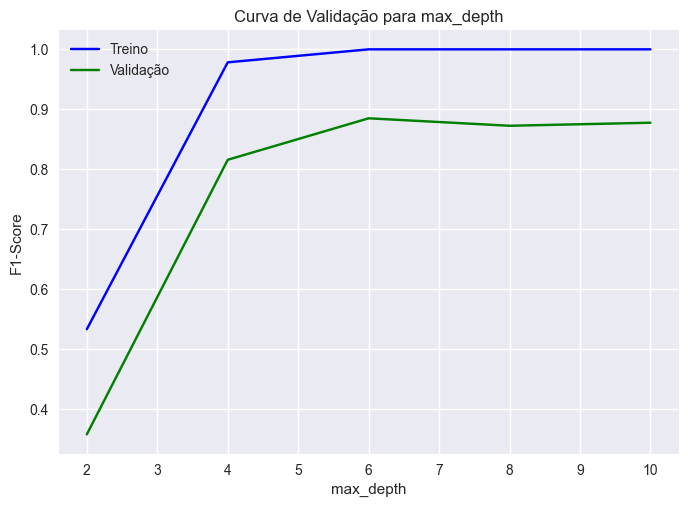

In [675]:
# Curva de Validação para o parâmetro max_depth
param_range = [2, 4, 6, 8, 10]
train_scores, test_scores = validation_curve(
    xgb.XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42),
    X_train, y_train,
    param_name="max_depth",
    param_range=param_range,
    scoring="f1",
    cv=5,
    n_jobs=-1
)

train_mean = np.mean(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)

print("Train Mean F1 Scores:", train_mean)
print("Validation Mean F1 Scores:", test_mean)

plt.plot(param_range, train_mean, label="Treino", color="blue")
plt.plot(param_range, test_mean, label="Validação", color="green")
plt.xlabel("max_depth")
plt.ylabel("F1-Score")
plt.title("Curva de Validação para max_depth")
plt.legend()
plt.show()


## Curva Precision-Recall

Essa curva avalia o desempenho do modelo focando na capacidade de equilíbrio entre precisão (proporção de previsões positivas corretas) e recall (proporção de positivos corretamente identificados).

Ela é especialmente importante para bases desbalanceadas, como a de atrição, pois mostra o trade-off entre capturar o maior número possível de positivos (recall) sem aumentar falsos positivos (baixar precisão).

O valor de Average Precision (AP) sintetiza essa relação, onde valores próximos de 1 indicam bom equilíbrio

Average Precision (AP): 0.9640


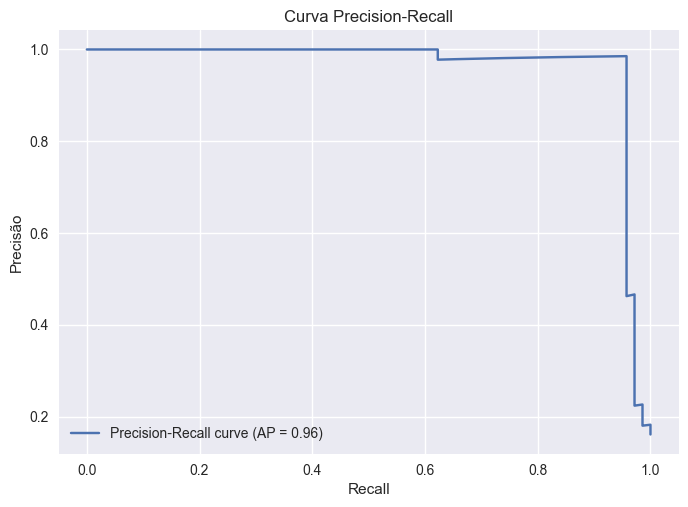

In [676]:
# Curva Precision-Recall
precision, recall, _ = precision_recall_curve(y_test, y_proba_opt)
ap_score = average_precision_score(y_test, y_proba_opt)

print(f"Average Precision (AP): {ap_score:.4f}")

plt.plot(recall, precision, label=f"Precision-Recall curve (AP = {ap_score:.2f})")
plt.xlabel("Recall")
plt.ylabel("Precisão")
plt.title("Curva Precision-Recall")
plt.legend()
plt.show()


# Modelagem Preditiva (Random Forest)

## Criando o Modelo Random Forest

In [677]:
# Criando o modelo base de Random Forest
rf_model = RandomForestClassifier(random_state=42, n_jobs=-1)

## Treinando o Modelo

In [678]:
# Treinando o modelo
rf_model.fit(X_train, y_train)

# Fazendo previsões no conjunto de teste
y_pred_rf = rf_model.predict(X_test)

### Validação Cruzada

In [679]:
# Definindo a estratégia de validação cruzada
rf_scoring_metrics = ['accuracy', 'precision', 'recall', 'f1', 'roc_auc']
rf_results = cross_validate(rf_model, X_train, y_train, cv=cv_strategy, scoring=rf_scoring_metrics, return_train_score=False)

#### Resultados da Validação Cruzada

In [680]:
# Avaliando o modelo final otimizado com as métricas de desempenho
print("Resultados da Validação Cruzada - Modelo Base Random Forest:")
for metric in rf_scoring_metrics:
    mean_score = rf_results[f'test_{metric}'].mean()
    std_score = rf_results[f'test_{metric}'].std()
    print(f"  - {metric.capitalize()}: {mean_score:.4f} (+/- {std_score:.4f})")

Resultados da Validação Cruzada - Modelo Base Random Forest:
  - Accuracy: 0.9613 (+/- 0.0092)
  - Precision: 0.9676 (+/- 0.0228)
  - Recall: 0.7859 (+/- 0.0467)
  - F1: 0.8667 (+/- 0.0339)
  - Roc_auc: 0.9742 (+/- 0.0104)


## Avaliação do Modelo Base Random Forest


Relatório de Classificação (Random Forest Base):
              precision    recall  f1-score   support

   Ficou (0)       0.99      1.00      0.99      1106
    Saiu (1)       0.98      0.93      0.96       212

    accuracy                           0.99      1318
   macro avg       0.99      0.96      0.97      1318
weighted avg       0.99      0.99      0.99      1318

------------------------------------------------------------
Acurácia:  0.9863
Precisão:  0.9850
Recall:    0.9292
F1-Score:  0.9563
------------------------------------------------------------
Verdadeiros Negativos (VN): 1103
Falsos Positivos (FP):      3
Falsos Negativos (FN):      15
Verdadeiros Positivos (VP): 197


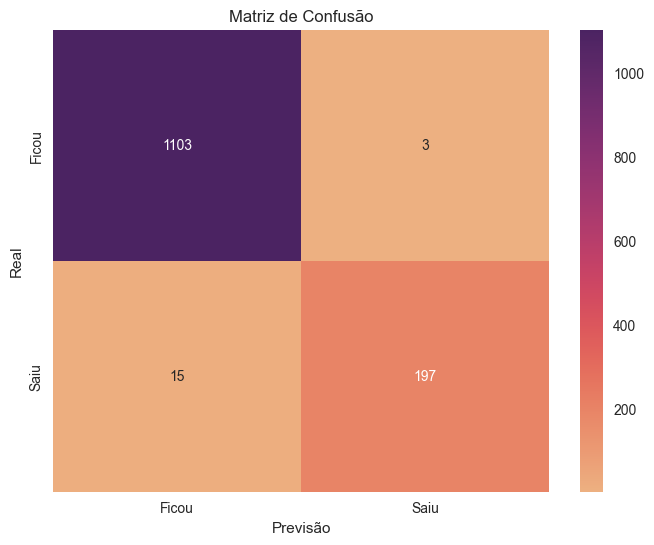


AUC Score Final (Random Forest): 0.9943


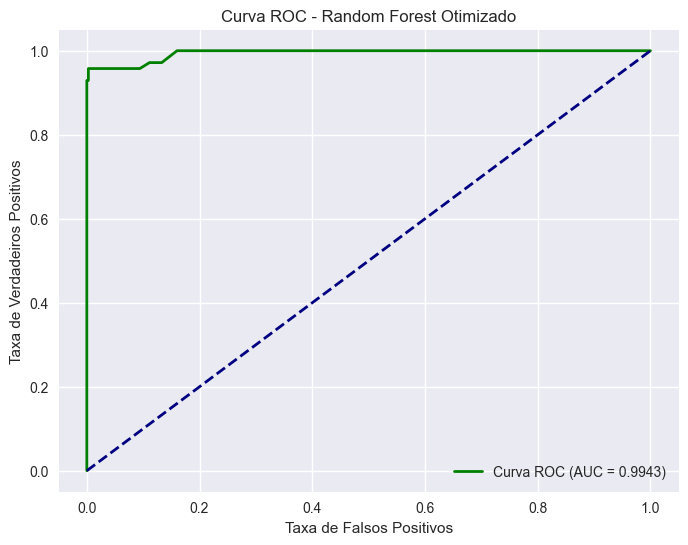

In [681]:
# Treinando o modelo final otimizado com os melhores hiperparâmetros
rf_model.fit(X_train, y_train)

# Fazendo previsões no conjunto de teste com o modelo final otimizado
y_pred_rf = rf_model.predict(X_test)
y_proba_rf = rf_model.predict_proba(X_test)[:, 1]

# Avaliando o modelo final otimizado
print("\nRelatório de Classificação (Random Forest Base):")
print(classification_report(y_test, y_pred_rf, target_names=['Ficou (0)', 'Saiu (1)']))

# Avaliando o modelo
# Métricas
acuracia_rf = accuracy_score(y_test, y_pred_rf)
precisao_rf = precision_score(y_test, y_pred_rf)
recall_rf = recall_score(y_test, y_pred_rf)
f1_rf = f1_score(y_test, y_pred_rf)

# Exibindo os resultados
print("-" * 60)
print(f"Acurácia:  {acuracia_rf:.4f}")
print(f"Precisão:  {precisao_rf:.4f}")
print(f"Recall:    {recall_rf:.4f}")
print(f"F1-Score:  {f1_rf:.4f}")
print("-" * 60)

# Matriz de Confusão Final
cm_rf = confusion_matrix(y_test, y_pred_rf)

# Atribui os valores
vn, fp, fn, vp = cm_rf.ravel()

# Exibe os resultados
print(f"Verdadeiros Negativos (VN): {vn}")
print(f"Falsos Positivos (FP):      {fp}")
print(f"Falsos Negativos (FN):      {fn}")
print(f"Verdadeiros Positivos (VP): {vp}")

plt.figure(figsize=(8, 6))
sns.heatmap(cm_rf, annot=True, fmt='d', cmap='flare', xticklabels=['Ficou', 'Saiu'], yticklabels=['Ficou', 'Saiu'])
plt.title('Matriz de Confusão')
plt.xlabel('Previsão')
plt.ylabel('Real')
plt.show()

# Calcula o AUC Score final para o modelo Random Forest otimizado
auc_rf = roc_auc_score(y_test, y_proba_rf)
print(f"\nAUC Score Final (Random Forest): {auc_rf:.4f}")

# Calcula os pontos da curva ROC para o modelo Random Forest otimizado
fpr_rf, tpr_rf, _ = roc_curve(y_test, y_proba_rf)
plt.figure(figsize=(8, 6))
plt.plot(fpr_rf, tpr_rf, color='green', lw=2, label=f'Curva ROC (AUC = {auc_rf:.4f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('Taxa de Falsos Positivos')
plt.ylabel('Taxa de Verdadeiros Positivos')
plt.title('Curva ROC - Random Forest Otimizado')
plt.legend(loc="lower right")
plt.show()

## Otimização do Random Forest

In [682]:
# Otimização de hiperparâmetros com RandomizedSearchCV para Random Forest
param_dist_rf = {
    'n_estimators': [100, 200, 300, 400],
    'max_depth': [10, 20, 30, None], # None = até que as folhas sejam puras
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['sqrt', 'log2'] # Opções padrão e eficientes
}

# Configurando a estratégia de validação cruzada
rf_random_search = RandomizedSearchCV(
    estimator=rf_model, # O seu rf_model base
    param_distributions=param_dist_rf,
    n_iter=50,
    scoring='f1',
    cv=cv_strategy, # A mesma estratégia de validação
    n_jobs=-1,
    random_state=42,
    verbose=1
)

# Iniciando a busca pelos melhores hiperparâmetros do Random Forest
rf_random_search.fit(X_train, y_train)

# Exibindo os melhores hiperparâmetros encontrados
print("Melhores Hiperparâmetros encontrados para o Random Forest:")
print(rf_random_search.best_params_)

# Exibindo o melhor score (F1-Score) encontrado na validação cruzada
print(f"\nMelhor F1-Score (na validação cruzada): {rf_random_search.best_score_:.4f}")

# Atribuindo o modelo otimizado à variável final_rf_model
final_rf_model = rf_random_search.best_estimator_
print("Modelo final otimizado:")
print(final_rf_model)

Fitting 5 folds for each of 50 candidates, totalling 250 fits
Melhores Hiperparâmetros encontrados para o Random Forest:
{'n_estimators': 300, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': 'log2', 'max_depth': None}

Melhor F1-Score (na validação cruzada): 0.8763
Modelo final otimizado:
RandomForestClassifier(max_features='log2', n_estimators=300, n_jobs=-1,
                       random_state=42)


### Avaliação do Modelo Random Forest Otimizado


Relatório de Classificação (Random Forest Otimizado):
              precision    recall  f1-score   support

   Ficou (0)       0.99      1.00      0.99      1106
    Saiu (1)       0.99      0.94      0.96       212

    accuracy                           0.99      1318
   macro avg       0.99      0.97      0.98      1318
weighted avg       0.99      0.99      0.99      1318

------------------------------------------------------------
Acurácia:  0.9886
Precisão:  0.9852
Recall:    0.9434
F1-Score:  0.9639
------------------------------------------------------------
Verdadeiros Negativos (VN): 1103
Falsos Positivos (FP):      3
Falsos Negativos (FN):      12
Verdadeiros Positivos (VP): 200


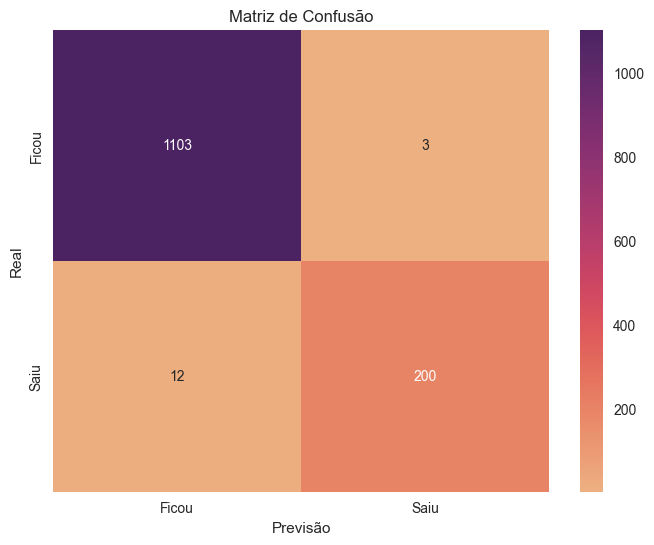


AUC Score Final (Random Forest): 0.9925


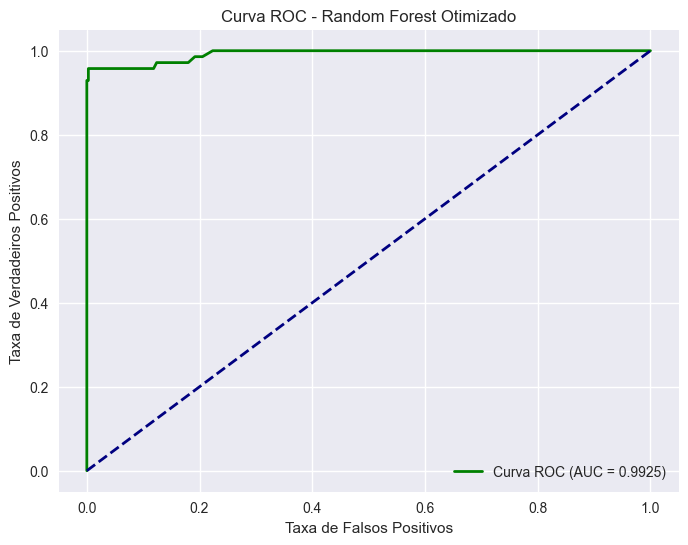

In [683]:
# Treinando o modelo final otimizado com os melhores hiperparâmetros
final_rf_model.fit(X_train, y_train)

# Fazendo previsões no conjunto de teste com o modelo final otimizado
y_pred_rf_final = final_rf_model.predict(X_test)
y_proba_rf_final = final_rf_model.predict_proba(X_test)[:, 1]

# Avaliando o modelo final otimizado
print("\nRelatório de Classificação (Random Forest Otimizado):")
print(classification_report(y_test, y_pred_rf_final, target_names=['Ficou (0)', 'Saiu (1)']))

# Avaliando o modelo
# Métricas
acuracia_rf_final = accuracy_score(y_test, y_pred_rf_final)
precisao_rf_final = precision_score(y_test, y_pred_rf_final)
recall_rf_final = recall_score(y_test, y_pred_rf_final)
f1_rf_final = f1_score(y_test, y_pred_rf_final)

# Exibindo os resultados
print("-" * 60)
print(f"Acurácia:  {acuracia_rf_final:.4f}")
print(f"Precisão:  {precisao_rf_final:.4f}")
print(f"Recall:    {recall_rf_final:.4f}")
print(f"F1-Score:  {f1_rf_final:.4f}")
print("-" * 60)

# Matriz de Confusão Final
cm_rf_final = confusion_matrix(y_test, y_pred_rf_final)

# Atribui os valores
vn, fp, fn, vp = cm_rf_final.ravel()

# Exibe os resultados
print(f"Verdadeiros Negativos (VN): {vn}")
print(f"Falsos Positivos (FP):      {fp}")
print(f"Falsos Negativos (FN):      {fn}")
print(f"Verdadeiros Positivos (VP): {vp}")

plt.figure(figsize=(8, 6))
sns.heatmap(cm_rf_final, annot=True, fmt='d', cmap='flare', xticklabels=['Ficou', 'Saiu'], yticklabels=['Ficou', 'Saiu'])
plt.title('Matriz de Confusão')
plt.xlabel('Previsão')
plt.ylabel('Real')
plt.show()

# Calcula o AUC Score final para o modelo Random Forest otimizado
auc_rf_final = roc_auc_score(y_test, y_proba_rf_final)
print(f"\nAUC Score Final (Random Forest): {auc_rf_final:.4f}")

# Calcula os pontos da curva ROC para o modelo Random Forest otimizado
fpr_rf, tpr_rf, _ = roc_curve(y_test, y_proba_rf_final)
plt.figure(figsize=(8, 6))
plt.plot(fpr_rf, tpr_rf, color='green', lw=2, label=f'Curva ROC (AUC = {auc_rf_final:.4f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('Taxa de Falsos Positivos')
plt.ylabel('Taxa de Verdadeiros Positivos')
plt.title('Curva ROC - Random Forest Otimizado')
plt.legend(loc="lower right")
plt.show()

## Importância das variáveis no Modelo Otimizado

Top 10 Features mais importantes segundo o Random Forest Otimizado:
                    Feature  Importance
0                       Age      0.1101
4             MonthlyIncome      0.1084
8         TotalWorkingYears      0.0929
1          DistanceFromHome      0.0762
10           YearsAtCompany      0.0727
6         PercentSalaryHike      0.0695
5        NumCompaniesWorked      0.0582
12     YearsWithCurrManager      0.0570
9     TrainingTimesLastYear      0.0449
11  YearsSinceLastPromotion      0.0443
--------------------------------------------------


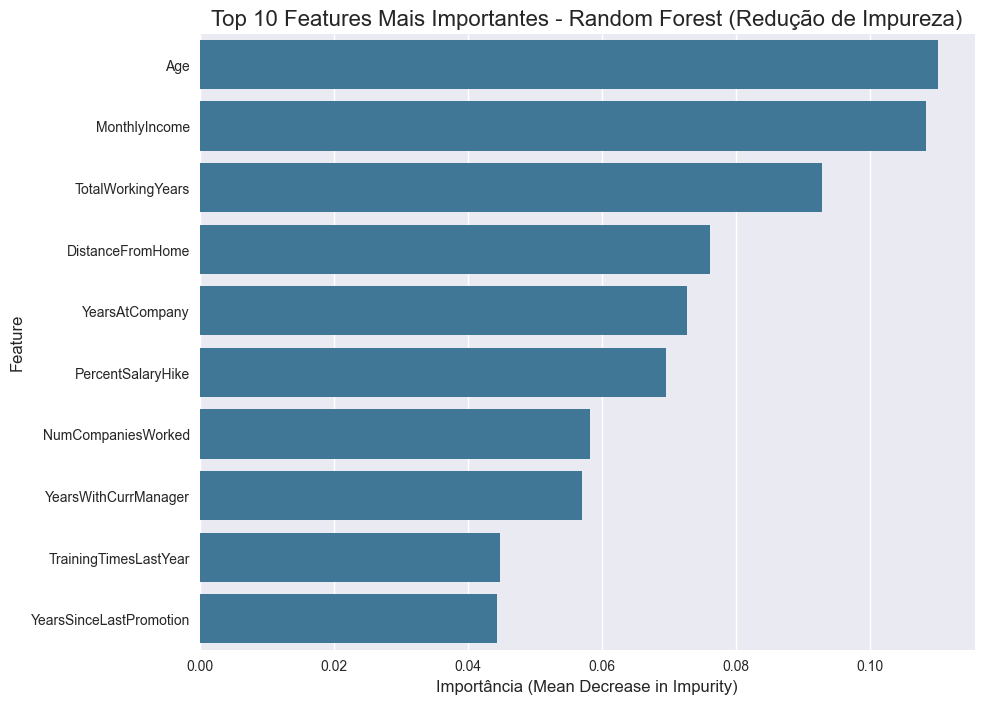

In [684]:
# Importância das variáveis do modelo Random Forest otimizado
importances_rf = final_rf_model.feature_importances_

# Criando um DataFrame para armazenar as importâncias das variáveis
feature_importance_df = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance': importances_rf
}).sort_values(by='Importance', ascending=False)

# Exibindo as 10 principais variáveis mais importantes
print("Top 10 Features mais importantes segundo o Random Forest Otimizado:")
print(feature_importance_df.head(10))
print("-" * 50)


# Gráfico de barras das 10 principais variáveis mais importantes
plt.figure(figsize=(10, 8))
sns.barplot(x='Importance', y='Feature', data=feature_importance_df.head(10), color='#327BA5')
plt.title('Top 10 Features Mais Importantes - Random Forest (Redução de Impureza)', fontsize=16)
plt.xlabel('Importância (Mean Decrease in Impurity)', fontsize=12)
plt.ylabel('Feature', fontsize=12)
plt.show()

# Benchmark dos Modelos 🤖⚔️🤖

## Coleta e Organização dos Dados do Benchmark

In [685]:
# Benchmark Final: XGBoost vs. Random Forest

# --- Coletando os resultados finais de ambos os modelos ---

# Métricas do XGBoost Otimizado
y_pred_xgb_final = final_xgb_model.predict(X_test)
y_proba_xgb_final = final_xgb_model.predict_proba(X_test)[:, 1]

f1_xgb = f1_score(y_test, y_pred_xgb_final)
recall_xgb = recall_score(y_test, y_pred_xgb_final)
precision_xgb = precision_score(y_test, y_pred_xgb_final)
auc_xgb = roc_auc_score(y_test, y_proba_xgb_final)

# Métricas do Random Forest Otimizado 
y_pred_rf_final = final_rf_model.predict(X_test)
y_proba_rf_final = final_rf_model.predict_proba(X_test)[:, 1]

f1_rf = f1_score(y_test, y_pred_rf_final)
recall_rf = recall_score(y_test, y_pred_rf_final)
precision_rf = precision_score(y_test, y_pred_rf_final)
auc_rf = roc_auc_score(y_test, y_proba_rf_final)

# --- Criando o DataFrame de Comparação ---
data = {
    'Métrica': ['F1-Score', 'Recall', 'Precisão', 'AUC Score'],
    'XGBoost': [f1_xgb, recall_xgb, precision_xgb, auc_xgb],
    'Random Forest Otimizado': [f1_rf, recall_rf, precision_rf, auc_rf]
}

# Criando o DataFrame e definindo a coluna 'Métrica' como índice
df_benchmark = pd.DataFrame(data).set_index('Métrica')

# Formatando para 4 casas decimais para uma melhor visualização
pd.options.display.float_format = '{:.4f}'.format

display(df_benchmark)

,XGBoost,Random Forest Otimizado
Métrica,,
F1-Score,0.9644,0.9639
Recall,0.9575,0.9434
Precisão,0.9713,0.9852
AUC Score,0.9747,0.9925


## Comparação Visual da Curva ROC

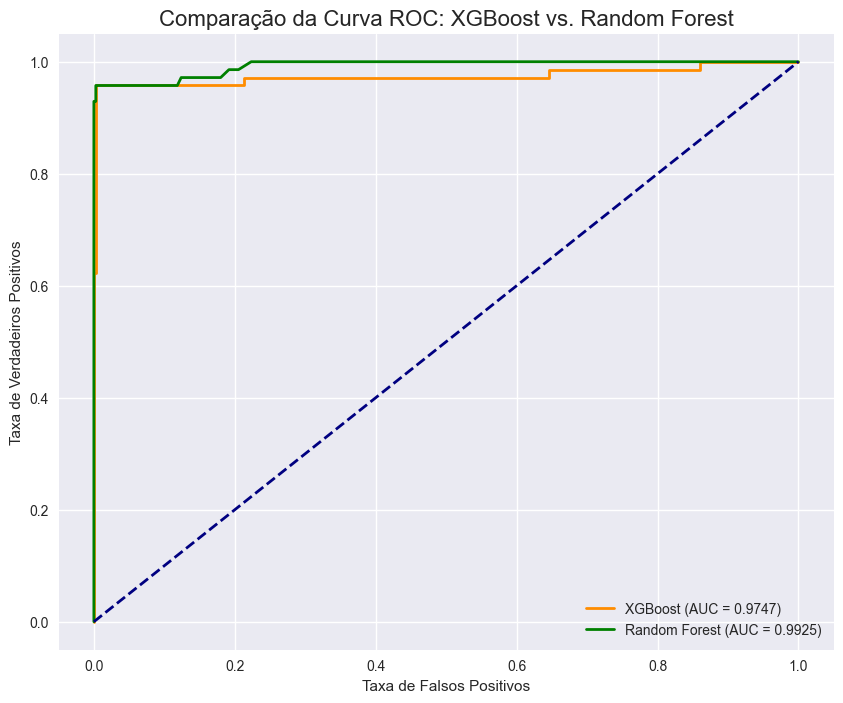

In [686]:
# Plotando a curva ROC para comparar os dois modelos
plt.figure(figsize=(10, 8))

# Curva ROC do XGBoost
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'XGBoost (AUC = {auc_xgb:.4f})')

# Curva ROC do Random Forest
plt.plot(fpr_rf, tpr_rf, color='green', lw=2, label=f'Random Forest (AUC = {auc_rf_final:.4f})')

# Linha de referência
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')

plt.xlabel('Taxa de Falsos Positivos')
plt.ylabel('Taxa de Verdadeiros Positivos')
plt.title('Comparação da Curva ROC: XGBoost vs. Random Forest', fontsize=16)
plt.legend(loc="lower right")
plt.grid(True)
plt.show()

# Análise de Viés

In [687]:
# Criar faixas etárias
X_test['faixa_etaria'] = pd.cut(X_test['Age'], bins=[18, 30, 45, 60, 100],
                                 labels=['18-30', '31-45', '46-60', '61+'])

# Adicionar as previsões e verdadeiros ao DataFrame
df_avaliacao = X_test.copy()
df_avaliacao['y_real'] = y_test.values
df_avaliacao['y_pred'] = y_pred_rf_final

# Avaliar desempenho por grupo etário
print("="*50)
print("ANÁLISE DE PERFORMANCE POR FAIXA ETÁRIA")
print("="*50)

grupos = df_avaliacao.groupby('faixa_etaria', observed=True)

# Resumo geral primeiro
print(f"\nDistribuição por faixa etária:")
print(df_avaliacao['faixa_etaria'].value_counts().sort_index())
print(f"\nTaxa de churn por faixa:")
taxa_churn = df_avaliacao.groupby('faixa_etaria')['y_real'].mean()
print(taxa_churn.sort_index())

print("\n" + "="*50)
print("MÉTRICAS DETALHADAS POR FAIXA")
print("="*50)

for faixa, grupo in grupos:
    print(f"\nFAIXA ETÁRIA: {faixa}")
    print(f"   Tamanho da amostra: {len(grupo)}")
    print(f"   Taxa real de churn: {grupo['y_real'].mean():.2%}")
    
    # Verifica se há pelo menos duas classes
    if grupo['y_real'].nunique() < 2:
        print("Grupo com apenas uma classe. Métricas não aplicáveis.")
        continue
    
    print(classification_report(grupo['y_real'], grupo['y_pred'], zero_division=0))
    print("-"*50)

ANÁLISE DE PERFORMANCE POR FAIXA ETÁRIA

Distribuição por faixa etária:
faixa_etaria
18-30    335
31-45    748
46-60    227
61+        0
Name: count, dtype: int64

Taxa de churn por faixa:
faixa_etaria
18-30   0.2597
31-45   0.1270
46-60   0.1189
61+        NaN
Name: y_real, dtype: float64

MÉTRICAS DETALHADAS POR FAIXA

FAIXA ETÁRIA: 18-30
   Tamanho da amostra: 335
   Taxa real de churn: 25.97%
              precision    recall  f1-score   support

           0       0.99      1.00      0.99       248
           1       1.00      0.97      0.98        87

    accuracy                           0.99       335
   macro avg       0.99      0.98      0.99       335
weighted avg       0.99      0.99      0.99       335

--------------------------------------------------

FAIXA ETÁRIA: 31-45
   Tamanho da amostra: 748
   Taxa real de churn: 12.70%
              precision    recall  f1-score   support

           0       0.99      1.00      0.99       653
           1       1.00      0.91  

C:\Users\Book\AppData\Local\Temp\ipykernel_4608\4016935453.py:21: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  taxa_churn = df_avaliacao.groupby('faixa_etaria')['y_real'].mean()


In [688]:
# Criar faixas de renda
bins_renda = [0, 30000, 50000, 80000, 120000, float('inf')]
labels_renda = ['Até 30k', '30k-50k', '50k-80k', '80k-120k', '120k+']

# Adicionar a coluna de faixa de renda ao DataFrame de avaliação
df_avaliacao['faixa_renda'] = pd.cut(df_avaliacao['MonthlyIncome'], 
                                     bins=bins_renda, 
                                     labels=labels_renda, 
                                     right=False)

# Exibir análise de performance por faixa de renda
print("\n" + "="*50)
print("ANÁLISE DE PERFORMANCE POR FAIXA DE RENDA")
print("="*50)

# Agrupar pela nova coluna 'faixa_renda'
grupos_renda = df_avaliacao.groupby('faixa_renda', observed=True)

# Resumo geral primeiro
print(f"\nDistribuição por faixa de renda:")
print(df_avaliacao['faixa_renda'].value_counts().sort_index())
print(f"\nTaxa de churn por faixa de renda:")
taxa_churn_renda = df_avaliacao.groupby('faixa_renda', observed=True)['y_real'].mean()
print(taxa_churn_renda.sort_index())

print("\n" + "="*50)
print("MÉTRICAS DETALHADAS POR FAIXA DE RENDA")
print("="*50)

# Iterar sobre cada grupo de renda e calcular as métricas
for faixa, grupo in grupos_renda:
    print(f"\nFAIXA DE RENDA: {faixa}")
    print(f"   Tamanho da amostra: {len(grupo)}")
    
    if len(grupo) > 0:
        print(f"Taxa real de churn: {grupo['y_real'].mean():.2%}")
    
    # Verifica se há pelo menos duas classes
    if grupo['y_real'].nunique() < 2:
        print("\n   Grupo com apenas uma classe. Métricas de classificação não aplicáveis.")
    else:
        # Usa a mesma coluna 'y_pred' que já tem as previsões do RF
        print(classification_report(grupo['y_real'], grupo['y_pred'], zero_division=0, target_names=['Ficou', 'Saiu']))
    
    print("-"*50)


ANÁLISE DE PERFORMANCE POR FAIXA DE RENDA

Distribuição por faixa de renda:
faixa_renda
Até 30k     338
30k-50k     312
50k-80k     313
80k-120k    174
120k+       181
Name: count, dtype: int64

Taxa de churn por faixa de renda:
faixa_renda
Até 30k    0.2071
30k-50k    0.1635
50k-80k    0.1629
80k-120k   0.1322
120k+      0.0939
Name: y_real, dtype: float64

MÉTRICAS DETALHADAS POR FAIXA DE RENDA

FAIXA DE RENDA: Até 30k
   Tamanho da amostra: 338
Taxa real de churn: 20.71%
              precision    recall  f1-score   support

       Ficou       0.99      1.00      0.99       268
        Saiu       1.00      0.96      0.98        70

    accuracy                           0.99       338
   macro avg       0.99      0.98      0.99       338
weighted avg       0.99      0.99      0.99       338

--------------------------------------------------

FAIXA DE RENDA: 30k-50k
   Tamanho da amostra: 312
Taxa real de churn: 16.35%
              precision    recall  f1-score   support

       F

# Insights de Negócio e Recomendações

#### É possível prever a rotatividade antes que ela aconteça?

Sim. O modelo final baseado em **Random Forest** apresentou **alta capacidade de identificar os funcionários que estão prestes a sair**, com **recall de 94,3%** e **precisão de 98,5%**. Isso significa que o modelo consegue prever a maioria dos casos reais de churn com **baixo índice de falsos alarmes**, tornando sua aplicação prática altamente confiável para ações de retenção direcionadas. 

#### Quais funcionários estão em maior risco de deixar a empresa?

A análise indicou um perfil de risco concentrado em três características principais:

- **Viajantes Frequentes**: Funcionários que se deslocam com frequência apresentaram maior taxa de saída. O desgaste da rotina parece ser um fator importante.
- **Representantes de Vendas**: Esta função mostrou-se mais sensível ao churn, possivelmente pela pressão por metas ou pela natureza competitiva da área.
- **Funcionários com Menor Renda**: A maior taxa de churn (21%) foi observada na faixa salarial de até 30 mil anuais. Esses profissionais, em sua maioria em início de carreira, podem ter menor vínculo com a empresa e maior propensão a buscar novas oportunidades.

#### Quais fatores influenciam a saída de um funcionário?

A análise de importância das variáveis mostrou que os principais fatores associados ao churn são:

- **Idade e Renda Mensal**: Funcionários mais jovens e com menor renda têm maior probabilidade de saída.
- **Total de Anos de Carreira**: Influencia mais do que o tempo na empresa atual, refletindo o momento da carreira do profissional.
- **Tempo com o Gestor Atual**: Um relacionamento consistente com a liderança está associado a maior permanência.


### Resumo

O desafio da retenção na HR Insights, segundo os dados analisados, está relacionado a três frentes principais:

1. **Sobrecarga operacional** (viagens frequentes)
2. **Pressão de função** (representantes de vendas)
3. **Desengajamento dos talentos na base da pirâmide** (baixa renda)

As estratégias mais eficazes de retenção serão aquelas que atuarem sobre esses três pilares de forma combinada.


### Recomendações Estratégicas

- **Planos de carreira e programas de reconhecimento** para cargos de entrada (até 30k).
- **Iniciativas de alívio de carga** para funções com viagens intensas (ex: home office pós-viagem, pausas programadas).
- **Capacitação de gestores** com altas taxas de churn em suas equipes, promovendo vínculos mais duradouros.
